In [1]:
'''
   Copyright 2023-2025 Spacebel s.a.

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
'''

'\n   Copyright 2023-2025 Spacebel s.a.\n\n   Licensed under the Apache License, Version 2.0 (the "License");\n   you may not use this file except in compliance with the License.\n   You may obtain a copy of the License at\n\n       http://www.apache.org/licenses/LICENSE-2.0\n\n   Unless required by applicable law or agreed to in writing, software\n   distributed under the License is distributed on an "AS IS" BASIS,\n   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n   See the License for the specific language governing permissions and\n   limitations under the License.\n'

# STAC API

## Overview

This notebook explains the use of the STAC API interface with GeoJSON response format. It uses the `pystac` [[RD17]](#RD17) and `pystac_client` [[RD18]](#RD18) libraries to access the interface. The visualisation of search results is borrowed from the ODC notebook available at [[RD19]](#RD19).  Examples using `curl` on the command-line are provided as well.

In [2]:
%pip install geopandas
# %pip install --force-reinstall -v "pystac_client==0.6.1"
# %pip install pystac_client==0.8.5  
%pip install pystac_client

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install folium matplotlib mapclassify
%pip install jsonpath_ng


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import folium
import folium.plugins
import geopandas as gpd
import shapely.geometry
import pandas as pd  
import numpy as np
import json
import urllib.parse
import requests

# from xml.dom import minidom
# from IPython.display import HTML, display
from IPython.display import Markdown as md
from pystac_client import Client
from pystac import Collection
from typing import Any, Dict
from urllib.parse import urlparse, parse_qsl
from matplotlib import pyplot as plt, cm, colors
from PIL import Image
from io import BytesIO
from branca.element import Figure
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    

def curl_command( url: str, method: str = "GET" ) -> str:
    """
    Convert request URL to equivalent curl GET or POST command-line
    for STAC search (bash shell).
    """
    c = "curl -X " + method
    res = urlparse(url)
    if "GET" in method:
        c = c + " -G " + res.scheme + "://" + res.netloc + res.path
    else:
        c = c + " " + res.scheme + "://" + res.netloc + res.path    \
              + " \\\n\t--header 'Content-Type: application/json'"  \
              + " \\\n\t--data-raw '{"
    
    lst = parse_qsl(res.query)
    
    first = True 
    for i in lst:
        # print(i[0])
        # add \ to end of previous line
        if "GET" in method:
            # correction 16/3: data-urlencode used.
            v = i[1].replace('"', '\\"')
            c = c + ' \\\n\t--data-urlencode "'+i[0]+'='+v+'"'
        else:
            if not(first):
                c = c + ','
                
            if i[0] in ["ids","collections"]:
                # "collections" and "ids") parameter has to be included as an array.
                lst = i[1].split(',')       
                c = c + '\n\t\t"'+i[0]+'": '+str(lst).replace("'","\"")
            
            elif is_number(i[1]) or i[1][0]=='{' or i[1][0]=='[':
                # do not surround with quotes if numerical value  or a json object or an array
                c = c + '\n\t\t"'+i[0]+'": '+i[1]
            else:
                c = c + '\n\t\t"'+i[0]+'": "'+i[1]+'"'
        first = False
        
    if "POST" in method:
        c = c + "\n\t}'"
    return c


def display_previews(results):
    """
    Helper method for displaying a grid of quicklooks (if available)
    """
    # create figure
    fig = plt.figure(figsize=(20, 20))
  
    # setting values to rows and column variables for the image grid
    rows = 8
    columns = 2
    pos = 1

    for item in results.items():
        # print(item.id)
        assets = item.assets
        try:
            # print("found thumbnail", assets['thumbnail'].href)
            url = assets['thumbnail'].href
            response = requests.get(url)
            Image1 = Image.open(BytesIO(response.content))
            # display at position 'pos'
            fig.add_subplot(rows, columns, pos)
            pos = pos+1
            # show the image
            plt.imshow(Image1)
            plt.axis('off')
            plt.title(item.id)
        except:
            pass
    return

def display_gdf_plot(results):
    """
    Helper method for displaying results as dataframe plot
    """
    # https://github.com/opendatacube/odc-stac (License Apache 2.0)
    # https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#Plot-STAC-Items-on-a-Map

    # Convert STAC items into a GeoJSON FeatureCollection
    stac_json = results.item_collection_as_dict()

    gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

    fig = gdf.plot(
        "datetime",
        edgecolor="black",
        categorical=True,
        aspect="equal",
        alpha=0.5,
        figsize=(6, 12),
        legend=True,
        legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
    )
    _ = fig.set_title("STAC Query Results")

    # gdf
    return

def display_date_distribution(results, column='start_datetime'):
    """
    Helper method for displaying number of results per year/month as bar chart
    """
    # items = list(results.items())
    stac_json = results.item_collection_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json)

    gdf['date'] = pd.to_datetime(gdf[column])
    # create a representation of the month with strfmt
    gdf['year_month'] = gdf['date'].map(lambda dt: dt.strftime('%Y-%m'))
    grouped_df = gdf.groupby('year_month')['year_month'].size().to_frame("count").reset_index()
    grouped_df.plot(kind='bar', x='year_month', y='count', title=column)
    return

def display_value_distribution(results, column):
    """
    Helper method for displaying number values in column as bar chart
    """
    # items = list(results.get_items())
    stac_json = results.item_collection_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json)

    # gdf['date'] = pd.to_datetime(gdf['start_datetime'])
    # create a representation of the month with strfmt
    # gdf['year_month'] = gdf['date'].map(lambda dt: dt.strftime('%Y-%m'))

    try:
        grouped_df = gdf.groupby(column)[column].size().to_frame("count").reset_index()
        grouped_df.plot(kind='bar', x=column, y='count', title=column)
    except:
        print(column + " values are not available.")

    return


def display_map(results):
    """
    Helper method for displaying results on a map
    """
    # https://github.com/python-visualization/folium/issues/1501
    stac_json = results.item_collection_as_dict()
    gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
    
    fig = Figure(width="800px", height="500px")
    map1 = folium.Map()
    fig.add_child(map1)

    # folium.GeoJson(
    #    shapely.geometry.box(*bbox),  # ??
    #    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    #    name="Query",
    # ).add_to(map1)

    gdf.explore(
        "start_datetime",
        categorical=True,
        tooltip=[
            "title", "datetime", "start_datetime", "platform", "instruments"    
        ],
        popup=True,
        style_kwds=dict(fillOpacity=0.1, width=2),
        name="STAC",
        m=map1,
    )

    map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
    display(fig)
    return


In [5]:
URL_LANDING_PAGE = 'https://catalog.maap.eo.esa.int/catalogue/'

In [6]:
COLLECTION_ID1 = 'PROBA.CHRIS.1A'
COLLECTION_ID2 = 'SPOT-6.and.7.ESA.archive'  
#COLLECTION_ID2_CLOUDS = 'LANDSAT.ETM.GTC'
COLLECTION_ID3_CLOUDS = 'IKONOS.ESA.archive'
#COLLECTION_ID4 = 'Deimos-1.and.2.ESA.archive' 
COLLECTION_ID6_MAAP = 'BiomassLevel1a'
# COLLECTION_ID7_MAAP = 'GCA'
COLLECTION_ID8_MAAP = 'BiomassCCIv5'
COLLECTION_ID9_MAAP = 'BiomassLevel2a'

```{index} double: STAC API ; landing page
```

### Access landing page

The landing page provides access to collections (rel="`data`"), child catalogs (rel="`child`") and the STAC item search endpoint (rel="`search`").
Get the catalogue landing page with links to other resources and available collections.

In [7]:
curl_str = curl_command(URL_LANDING_PAGE)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/
```


In [8]:
from pystac_client import Client 

api = Client.open(URL_LANDING_PAGE) 
# show as a dictionary
api.to_dict()

{'type': 'Catalog',
 'id': 'fedeo',
 'stac_version': '1.1.0',
 'description': 'MAAP Catalogue provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata',
 'links': [{'rel': 'self',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/',
   'type': 'application/json'},
  {'rel': 'search',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/api?httpAccept=application/opensearchdescription%2Bxml',
   'type': 'application/opensearchdescription+xml',
   'title': 'OpenSearch Description Document'},
  {'rel': 'service-desc',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/api?httpAccept=application/vnd.oai.openapi%2Bjson;version=3.0',
   'type': 'application/vnd.oai.openapi+json;version=3.0',
   'title': 'OpenAPI definition in JSON format'},
  {'rel': 'data',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/collections',
   'type': 'application/json',
   'title': 'Metadata about the feature collections'},
  {'rel': 'data',
   'href': 'h

In [9]:
# Get catalog title and description
print("Title\t\t:", api.title)
print("Description\t:", api.description)
print("Search link\t:", api.get_search_link())

Title		: MAAP Catalogue
Description	: MAAP Catalogue provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata
Search link	: <Link rel=search target=https://catalog.maap.eo.esa.int/catalogue/search>


```{index} double: pystac_client ; collection search
```
```{index} double: STAC API ; collection search
```
## Collection Search

The API implements the STAC API Collection Search Extension [[RD25]](#RD25).
Available collections can be retrieved from the landing page using a paging mechanism (with rel="`next`" links).  It requires the compliance class to be present.  As `pystac_client` does not support collection search, the `requests` library is used in the examples. 

In [10]:
md(f"The collection endpoint is available as rel='`data`' link at JSONPath $.links[?(@.rel=='data')].  Alternatively, collections can be found by traversing the root catalog (i.e. landing page) and following the rel='`child`' links recursively.  Searchable collections have type: 'Collection' and do not have year/month/day information in their id.  E.g. `{COLLECTION_ID1}` is a searchable collection, \
while `{COLLECTION_ID1}-2022` or `{COLLECTION_ID1}-2022-12` or `{COLLECTION_ID1}-2022-12-06` cannot be used for STAC Item Search.  This limitation may be relaxed in future versions.")

The collection endpoint is available as rel='`data`' link at JSONPath $.links[?(@.rel=='data')].  Alternatively, collections can be found by traversing the root catalog (i.e. landing page) and following the rel='`child`' links recursively.  Searchable collections have type: 'Collection' and do not have year/month/day information in their id.  E.g. `PROBA.CHRIS.1A` is a searchable collection, while `PROBA.CHRIS.1A-2022` or `PROBA.CHRIS.1A-2022-12` or `PROBA.CHRIS.1A-2022-12-06` cannot be used for STAC Item Search.  This limitation may be relaxed in future versions.

In [11]:
from jsonpath_ng.ext import parse

response = requests.get(URL_LANDING_PAGE)
data = json.loads(response.text)
expression = parse("$.links[?(@.rel == 'data')].href")
r = expression.find(data)
r[0].value

'https://catalog.maap.eo.esa.int/catalogue/collections'

In [12]:
# retrieve /collections response
response = requests.get(r[0].value)
data = json.loads(response.text)
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "collections": [
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     null,
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "license": "various",
         "itemType": "feature",
         "description": "Metadata records representing EO series (a.k.a. EO collections).",
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items",
               "type": "application/geo+json",
               "title": "Series"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series?httpAccept=text/html",
               "type": "text/html",
               "title": "Self as HTML"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "Self as JSON-LD"
            },
            {
               "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/queryables",
               "type": "application/schema+json",
               "title": "Queryables for series"
            },
            {
               "rel": "describedBy",
               "href": "http://schemas.opengis.net/eoc-geojson/1.0/eoc-geojson-schema.json",
               "type": "application/schema+json",
               "title": "JSON schema for items belonging to this collection"
            }
         ],
         "id": "series",
         "title": "EO Series",
         "type": "Collection"
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     null,
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "license": "various",
         "itemType": "feature",
         "description": "Metadata records representing EO datasets (a.k.a. EO products)",
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/datasets",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/datasets/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json",
               "title": "Datasets"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/datasets?httpAccept=text/html",
               "type": "text/html",
               "title": "Self as HTML"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/datasets?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "Self as JSON-LD"
            },
            {
               "rel": "describedBy",
               "href": "http://schemas.opengis.net/eo-geojson/1.0/eo-geojson-schema.json",
               "type": "application/schema+json",
               "title": "JSON schema for items belonging to this collection"
            }
         ],
         "id": "datasets",
         "title": "EO Products",
         "type": "Collection"
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "2014-10-01T00:00:00.000Z",
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "keywords": [
            "FedEO",
            "SCIHUB",
            "DIF10",
            "land",
            "land cover",
            "sea",
            "ice",
            "natural disaster",
            "Soils",
            "Land Use and Land Cover",
            "Natural Hazards and Disaster Risk",
            "EARTH SCIENCE > AGRICULTURE > SOILS",
            "EARTH SCIENCE > LAND SURFACE > SOILS",
            "EARTH SCIENCE > LAND SURFACE > LAND USE/LAND COVER",
            "EARTH SCIENCE > HUMAN DIMENSIONS > NATURAL HAZARDS",
            "Imaging Radars",
            "Sentinel-1",
            "SAR"
         ],
         "created": "2014-10-01T00:00:00.00Z",
         "description": "The Sentinel-1 mission is the European Radar Observatory for the Copernicus joint initiative of the European Commission (EC) and the European Space Agency (ESA). The Sentinel-1 mission includes C-band imaging operating in four exclusive imaging modes with different resolution (down to 5 m) and coverage (up to 400 km). It provides dual polarization capability, short revisit times and rapid product delivery. Additionally, precise measurements of spacecraft position and attitude are available for every observation [https://dataspace.copernicus.eu/explore-data/data-collections/sentinel-data/sentinel-1].",
         "collection": "EOP:EU:DATASPACE",
         "type": "Collection",
         "title": "Sentinel-1",
         "license": "various",
         "assets": {
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json",
               "title": "Datasets search for the series EOP:ESA:Sentinel-1"
            },
            {
               "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:SCIHUB:S1/queryables",
               "type": "application/schema+json",
               "title": "Queryables for EOP:ESA:SCIHUB:S1"
            },
            {
               "rel": "search",
               "href": "https://fedeo.ceos.org/opensearch/description.xml?parentIdentifier=EOP:ESA:SCIHUB:S1",
               "title": "FedEO Clearinghouse - FedEO Clearinghouse"
            },
            {
               "rel": "search",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/EOP:ESA:SCIHUB:S1/api",
               "type": "application/opensearchdescription+xml",
               "title": "OpenSearch Description Document"
            },
            {
               "rel": "describedby",
               "href": "https://sentinel.esa.int/web/sentinel/missions/sentinel-1",
               "type": "text/html",
               "title": "ESA Sentinel Online"
            },
            {
               "rel": "describedby",
               "href": "https://dataspace.copernicus.eu",
               "type": "text/html",
               "title": "Copernicus Data Space Ecosystem - Copernicus Data Space Ecosystem"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?parentIdentifier=EOP:EU:DATASPACE&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?parentIdentifier=EOP:EU:DATASPACE&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?parentIdentifier=EOP:EU:DATASPACE&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?parentIdentifier=EOP:EU:DATASPACE&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/EOP:ESA:Sentinel-1?parentIdentifier=EOP:EU:DATASPACE&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "EOP:ESA:Sentinel-1",
         "updated": "2017-04-30T00:00:00.00Z",
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "instruments": [
               "SAR"
            ],
            "platform": [
               "Sentinel-1"
            ]
         }
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "2024-07-31T00:00:00.000Z",
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "keywords": [
            "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
            "EARTH SCIENCE > AGRICULTURE > FOREST SCIENCE > AFFORESTATION/REFORESTATION",
            "Forestry",
            "Afforestation/Reforestation",
            "conditionsUnknown",
            "Imaging Radars",
            "Biomass",
            "P-SAR"
         ],
         "created": "2023-02-16T00:00:00.00Z",
         "description": "Biomass Auxiliary external Products",
         "collection": "EOP:ESA:MAAP",
         "type": "Collection",
         "title": "Biomass Auxiliary external",
         "license": "various",
         "assets": {
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "license",
               "href": "https://earth.esa.int/eogateway/documents/d/earth-online/esa-eo-data-policy",
               "type": "application/x-binary",
               "title": "Access to and use of BIOMASS products are governed by the ESA's Data Policy and require acceptance of the specific Terms & Conditions. By accessing Biomass products, users inherently acknowledge and agree to these terms."
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "title": "Get Help? - ESA TellUS Help Page"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassAuxExt?parentIdentifier=EOP:ESA:MAAP&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "BiomassAuxExt",
         "updated": "2023-02-16T00:00:00.00Z",
         "stac_extensions": [
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json"
         ],
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN",
               "url": "https://www.esa.int"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "processing:level": [
               "L0"
            ],
            "instruments": [
               "P-SAR"
            ],
            "platform": [
               "Biomass"
            ]
         }
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "1991-08-01T00:00:00.000Z",
                     "2003-06-22T23:59:59.999Z"
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "sci:doi": "10.5270/ERS-suu0xfp",
         "keywords": [
            "DIF10",
            "EARTH SCIENCE>AGRICULTURE>FOREST SCIENCE>FOREST FIRE SCIENCE",
            "EARTH SCIENCE>ATMOSPHERE",
            "EARTH SCIENCE>ATMOSPHERE>ATMOSPHERIC TEMPERATURE",
            "EARTH SCIENCE>OCEANS",
            "ERS-1",
            "ERS-2",
            "ATSR",
            "ATSR-2",
            "Forest Fires",
            "Atmosphere",
            "Atmospheric Temperature",
            "Oceans",
            "VIS (0.40 - 0.75 \u00c2\u00b5m)",
            "NIR (0.75 - 1.30 \u00c2\u00b5m)",
            "SWIR (1.3 - 3.0 \u00c2\u00b5m)",
            "MWIR (3.0 - 6.0 \u00c2\u00b5m)",
            "TIR (6.0 - 15.0 \u00c2\u00b5nm)",
            "Sun-synchronous",
            "Low Resolution - LR (500 - 1200 m)",
            "800 km",
            "500 km",
            "Imaging Spectrometers/Radiometers",
            "ATSR-1"
         ],
         "created": "2024-04-10T00:00:00.00Z",
         "description": "The ERS-1/2 ATSR Level 1B Brightness Temperature/Radiance products (RBT) contain top of atmosphere (TOA) brightness temperature (BT) values for the infra-red channels and radiance values for the visible channels, when available, on a 1-km pixel grid. The visible channels are only available for the ATSR-2 instrument.\rValues for each channel and for the nadir and oblique views occupy separate NetCDF files within the Sentinel-SAFE format, along with associated uncertainty estimates. Additional files contain cloud flags, land and water masks, and confidence flags for each image pixel, as well as instrument and ancillary meteorological information.\rThe ATSR-1 and ATSR-2 products [ER1_AT_1_RBT and ER2_AT_1_RBT], in NetCDF format stemming from the 4th ATSR reprocessing, are precursors of Envisat AATSR and Sentinel-3 SLSTR data. They have replaced the former L1B products [AT1_TOA_1P and AT2_TOA_1P] in Envisat format from the 3rd reprocessing. \rUsers with Envisat-format products are recommended to move to the new Sentinel-SAFE like/NetCDF format products, and consult the ERS _$$ATSR Product Notice Readme document$$ https://earth.esa.int/eogateway/documents/20142/37627/ATSR-Level-1B-ERn-AT-1-RBT-Product-Notices-Readme.pdf  \rThe processing updates that have been put in place and the expected scientific improvements for the ERS ATSR 4th reprocessing data have been outlined in full in the _$$User Documentation for (A)ATSR 4th Reprocessing Products$$ https://earth.esa.int/documents/20142/37627/QA4EO-VEG-OQC-MEM-4538_User_Documentation_for__A_ATSR_4th_Reprocessing_Level_1.pdf .",
         "sci:citation": "European Space Agency, 2024, ERS ATSR L1B Brightness Temperature/Radiance [ER1_AT_1_RBT / ER2_AT_1_RBT], Version 4.0.",
         "collection": "EOP:ESA:EARTH-ONLINE",
         "type": "Collection",
         "title": "ERS ATSR L1B Brightness Temperature/Radiance [ER1_AT_1_RBT / ER2_AT_1_RBT]",
         "license": "various",
         "assets": {
            "enclosure_1": {
               "roles": [
                  "data"
               ],
               "href": "https://aatsr-ds.eo.esa.int/oads/meta/ERS-1ATSR/index/",
               "type": "text/html",
               "title": "OADS repository - OADS repository"
            },
            "enclosure_2": {
               "roles": [
                  "data"
               ],
               "href": "https://aatsr-ds.eo.esa.int/oads/meta/ERS-2ATSR/index/",
               "type": "text/html",
               "title": "OADS repository - OADS repository"
            },
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "cite-as",
               "href": "https://doi.org/10.5270/ERS-suu0xfp",
               "type": "text/html",
               "title": "Landing page"
            },
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json",
               "title": "Datasets search for the series ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40"
            },
            {
               "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40/queryables",
               "type": "application/schema+json",
               "title": "Queryables for ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40"
            },
            {
               "rel": "search",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40/api",
               "type": "application/opensearchdescription+xml",
               "title": "OpenSearch Description Document"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ERSATSRL1BBrightnessTemperatureRadianceER1AT1RBTER2AT1RBT40",
         "updated": "2024-10-08T06:39:36Z",
         "stac_extensions": [
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json",
            "https://stac-extensions.github.io/scientific/v1.0.0/schema.json"
         ],
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN",
               "url": "https://earth.esa.int"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "processing:level": [
               "1B"
            ],
            "instruments": [
               "ATSR-1",
               "ATSR-2"
            ],
            "platform": [
               "ERS-1",
               "ERS-2"
            ]
         }
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "2002-10-18T00:00:00.000Z",
                     "2012-04-08T23:59:59.999Z"
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "sci:doi": "10.5270/EN1-q74d24h",
         "keywords": [
            "DIF10",
            "EARTH SCIENCE>AGRICULTURE>SOILS",
            "EARTH SCIENCE>BIOSPHERE>VEGETATION",
            "EARTH SCIENCE>HUMAN DIMENSIONS>NATURAL HAZARDS",
            "EARTH SCIENCE>OCEANS",
            "EARTH SCIENCE>OCEANS>OCEAN WAVES",
            "EARTH SCIENCE>OCEANS>MARINE ENVIRONMENT MONITORING>MARINE OBSTRUCTIONS",
            "ENVISAT",
            "ASAR",
            "Soils",
            "Vegetation",
            "Natural Hazards and Disaster Risk",
            "Oceans",
            "Ocean Waves",
            "Coastal Processes",
            "Sun-synchronous",
            "800 km",
            "5 - 1150 km",
            "Imaging Radars",
            "Envisat"
         ],
         "created": "2019-05-21T00:00:00.00Z",
         "description": "The ASAR Image Mode source packets Level 0 data product offers Level 0 data for possible images processing on an other processing site. It includes some mandatory information for SAR processing. The Image Mode Level 0 product consists of time-ordered Annotated Instrument Source Packets (AISPs) collected by the instrument in Image Mode. The echo samples contained in the AISPs are compressed to 4 bits/sample using Flexible Block Adaptive Quantisation (FBAQ). This is a high-rate, narrow swath mode so data is only acquired for partial orbit segments and may be from one of seven possible image swaths. The Level 0 product is produced systematically for all data acquired within this mode. This product provides a continuation of the ERS-SAR_RAW product.",
         "sci:citation": "European Space Agency, 2016, Envisat ASAR Image Mode L0 Product. IPF Version 6.03.",
         "collection": "EOP:ESA:EARTH-ONLINE",
         "type": "Collection",
         "title": "Envisat ASAR IM L0 [ASA_IM__0P]",
         "license": "various",
         "assets": {
            "enclosure": {
               "roles": [
                  "data"
               ],
               "href": "https://esar-ds.eo.esa.int/oads/meta/ASA_IM__0P_Scenes/index/",
               "type": "text/html",
               "title": "OADS repository - OADS repository"
            },
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "cite-as",
               "href": "https://doi.org/10.5270/EN1-q74d24h",
               "type": "text/html",
               "title": "Landing page"
            },
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json",
               "title": "Datasets search for the series ENVISAT.ASA.IM__0P"
            },
            {
               "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P/queryables",
               "type": "application/schema+json",
               "title": "Queryables for ENVISAT.ASA.IM__0P"
            },
            {
               "rel": "license",
               "href": "https://earth.esa.int/eogateway/documents/20142/1564626/Terms-and-Conditions-for-the-use-of-ESA-Data.pdf",
               "type": "application/pdf",
               "title": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions"
            },
            {
               "rel": "search",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/ENVISAT.ASA.IM__0P/api",
               "type": "application/opensearchdescription+xml",
               "title": "OpenSearch Description Document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/instruments/asar/products-information",
               "type": "text/html",
               "title": "Envisat ASAR Sensor Performance, Products and Algorithms - Product Information"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/Envisat-ASAR-science-and-applications.pdf",
               "type": "application/pdf",
               "title": "Envisat ASAR Science and Applications - Technical Note"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?skipDetection=true&text=&category=Document%20library&filter=asar",
               "type": "text/html",
               "title": "More ASAR Documents - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/ASAR-Product-Handbook.pdf",
               "type": "application/pdf",
               "title": "ASAR Product Handbook - User Manual"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?text=&category=Tools%20and%20toolboxes&filter=asar",
               "type": "text/html",
               "title": "ASAR Software Tools - Tools"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?category=tools+and+toolboxes&mission=envisat&tools_type=analysis%2Cprocessing&instrument=asar",
               "type": "text/html",
               "title": "ENVISAT Software tools - Software Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ENVISAT.ASA.IM__0P?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ENVISAT.ASA.IM__0P",
         "updated": "2025-02-04T13:52:03Z",
         "stac_extensions": [
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json",
            "https://stac-extensions.github.io/scientific/v1.0.0/schema.json"
         ],
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN",
               "url": "http://www.esa.int"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "processing:level": [
               "0"
            ],
            "instruments": [
               "ASAR"
            ],
            "platform": [
               "Envisat"
            ]
         }
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -26,
                     -37,
                     53,
                     37
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "2006-07-09T00:00:00.000Z",
                     "2009-05-12T23:59:59.999Z"
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "sci:doi": "10.5270/AL1-a06d3ac",
         "keywords": [
            "DIF10",
            "EARTH SCIENCE>HUMAN DIMENSIONS>NATURAL HAZARDS",
            "EARTH SCIENCE>BIOSPHERE>ECOSYSTEMS>TERRESTRIAL ECOSYSTEMS>FORESTS",
            "EARTH SCIENCE>AGRICULTURE",
            "EARTH SCIENCE>LAND SURFACE",
            "EARTH SCIENCE>CRYOSPHERE>SNOW/ICE",
            "ALOS",
            "AVNIR-2",
            "PRISM",
            "Natural Hazards and Disaster Risk",
            "Forestry",
            "Agriculture",
            "Land Surface",
            "Snow and Ice",
            "VIS (0.40 - 0.75 \u00b5m)",
            "NIR (0.75 - 1.30 \u00b5m)",
            "Sun-synchronous",
            "High Resolution - HR (5 - 20 m)",
            "Medium Resolution - MR (20 - 500 m)",
            "AV2_OBS_11",
            "PSM_OB1_11",
            "691.65 km",
            "35 km PRISM, 70 km AVNIR-2",
            "Imaging Spectrometers/Radiometers",
            "ALOS-1"
         ],
         "created": "2019-05-23T00:00:00.00Z",
         "description": "ALOS Africa is a dataset of the best available (cloud minimal, below 10%) African coverage acquired by AVNIR-2 in OBS mode and PRISM in OB1 mode (all Backward, Nadir and Forward views, in separated products), two different collections one for each instrument. The processing level for both AVNIR-2 and PRISM products is L1B.",
         "sci:citation": "European Space Agency, 2021, ALOS African Coverage ESA archive, Version 1.0.",
         "collection": "EOP:ESA:EARTH-ONLINE",
         "type": "Collection",
         "title": "Alos African Coverage ESA archive",
         "license": "various",
         "assets": {
            "enclosure_1": {
               "roles": [
                  "data"
               ],
               "href": "https://alos-ds.eo.esa.int/oads/meta/ALOS_Africa_PRISM/index/",
               "type": "text/html",
               "title": "OADS repository - OADS repository"
            },
            "enclosure_2": {
               "roles": [
                  "data"
               ],
               "href": "https://alos-ds.eo.esa.int/oads/meta/ALOS_Africa_AVNIR2/index/",
               "type": "text/html",
               "title": "OADS repository - OADS repository"
            },
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "cite-as",
               "href": "https://doi.org/10.5270/AL1-a06d3ac",
               "type": "text/html",
               "title": "Landing page"
            },
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json",
               "title": "Datasets search for the series ALOS"
            },
            {
               "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS/queryables",
               "type": "application/schema+json",
               "title": "Queryables for ALOS"
            },
            {
               "rel": "license",
               "href": "https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
               "type": "application/pdf",
               "title": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions"
            },
            {
               "rel": "search",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/ALOS/api",
               "type": "application/opensearchdescription+xml",
               "title": "OpenSearch Description Document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/ALOS-PALSAR-Product-Format-Description-Level-1-1.5.pdf",
               "type": "application/pdf",
               "title": "JAXA Level 1.1 and 1.5 data format - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/Information-on-ALOS-AVNIR-2-PRISM-Products-for-ADEN-users.pdf",
               "type": "application/pdf",
               "title": "Information on ALOS Optical products for ADEN users - Technical Note"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/ALOS-user-handbook.pdf",
               "type": "application/pdf",
               "title": "ALOS User Handbook - Product Description"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/search?category=tools+and+toolboxes&mission=alos-1&tools_type=analysis%2Cprocessing",
               "type": "text/html",
               "title": "ALOS Software tools - Software Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ALOS?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ALOS",
         "updated": "2025-02-04T13:52:03Z",
         "stac_extensions": [
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json",
            "https://stac-extensions.github.io/scientific/v1.0.0/schema.json"
         ],
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN",
               "url": "http://www.esa.int"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "processing:level": [
               "1B"
            ],
            "instruments": [
               "PRISM"
            ],
            "platform": [
               "ALOS-1"
            ]
         }
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -120,
                     19,
                     95,
                     87
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "1987-09-08T00:00:00.000Z",
                     "1993-09-30T23:59:59.999Z"
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "sci:doi": "10.5270/ESA-c26d993",
         "keywords": [
            "DIF10",
            "EARTH SCIENCE>CRYOSPHERE",
            "EARTH SCIENCE>OCEANS",
            "EARTH SCIENCE>CRYOSPHERE>SEA ICE",
            "EARTH SCIENCE>OCEANS>SEA SURFACE TOPOGRAPHY",
            "MOS-1",
            "MOS-1B",
            "VTIR",
            "Cryosphere",
            "Oceans",
            "Sea Ice",
            "Sea Surface Topography",
            "VIS (0.40 - 0.75 \u00c2\u00b5m)",
            "NIR (0.75 - 1.30 \u00c2\u00b5m)",
            "Sun-synchronous",
            "Medium Resolution - MR (20 - 500 m)",
            "VTI_SYC_1P",
            "909 km",
            "100 km",
            "Imaging Spectrometers/Radiometers",
            "MOS-1A"
         ],
         "created": "2024-01-11T00:00:00.00Z",
         "description": "The ESA System Corrected (Level 1) MOS-1/1B VTIR Products collection is composed of MOS-1/1B VTIR (Visible and Thermal Infrared Radiometer) data products generated as part of the MOS Bulk Processing Campaign using the MOS Processor v3.02.\r\rThe products are available in GeoTIFF format and disseminated within EO-SIP packaging. Please refer to the MOS Product Format Specification for further details.\rThe collection consists of data products of the following type:\r\rVTI_SYC_1P: System corrected Level 1 MOS-1/1B VTIR products in EO-SIP format. \r\rBand\tWavelength Range (\u00b5m)\tSpatial Resolution (km)\tSwath Width (km)\r1 (VIS)\t0.5 \u2013 0.7\t 0.9\t 1500\r2 (TIR)\t6.0 \u2013 7.0\t 2.7\t 1500\r3 (TIR)\t10.5 \u2013 11.5\t 2.7\t 1500\r4 (TIR)\t11.5 \u2013 12.5\t 2.7\t 1500",
         "sci:citation": "European Space Agency, 2023, MOS-1/1B ESA System Corrected VTIR Products [VTI_SYC_1P], Version 1.0.",
         "collection": "EOP:ESA:EARTH-ONLINE",
         "type": "Collection",
         "title": "MOS-1/1B ESA System Corrected VTIR Products [VTI_SYC_1P]",
         "license": "various",
         "assets": {
            "enclosure": {
               "roles": [
                  "data"
               ],
               "href": "https://tpm-ds.eo.esa.int/oads/meta/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product/index/",
               "type": "text/html",
               "title": "OADS repository - OADS repository"
            },
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "cite-as",
               "href": "https://doi.org/10.5270/ESA-c26d993",
               "type": "text/html",
               "title": "Landing page"
            },
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json",
               "title": "Datasets search for the series ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product"
            },
            {
               "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product/queryables",
               "type": "application/schema+json",
               "title": "Queryables for ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product"
            },
            {
               "rel": "search",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product/api",
               "type": "application/opensearchdescription+xml",
               "title": "OpenSearch Description Document"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "ESA_System_corrected_Level_1_MOS_1_1B_VTIR_product",
         "updated": "2025-02-04T13:52:03Z",
         "stac_extensions": [
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json",
            "https://stac-extensions.github.io/scientific/v1.0.0/schema.json"
         ],
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN",
               "url": "https://earth.esa.int"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "processing:level": [
               "1"
            ],
            "instruments": [
               "VTIR",
               "VTIR"
            ],
            "platform": [
               "MOS-1A",
               "MOS-1B"
            ]
         }
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -19,
                     -26,
                     35,
                     66
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "2010-07-20T00:00:00.000Z",
                     "2015-07-19T23:59:59.999Z"
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "keywords": [
            "DIF10",
            "EARTH SCIENCE>AGRICULTURE",
            "EARTH SCIENCE>BIOSPHERE>ECOSYSTEMS>TERRESTRIAL ECOSYSTEMS>FORESTS",
            "EARTH SCIENCE>LAND SURFACE",
            "EARTH SCIENCE>BIOSPHERE>VEGETATION",
            "EARTH SCIENCE>HUMAN DIMENSIONS>HUMAN SETTLEMENTS",
            "WORLDVIEW-2",
            "WV110",
            "Agriculture",
            "Forestry",
            "Land Surface",
            "Vegetation",
            "Human Settlements",
            "VIS (0.40 - 0.75 \u00b5m)",
            "NIR (0.75 - 1.30 \u00b5m)",
            "Sun-synchronous",
            "Very High Resolution - VHR (0 - 5m)",
            "WV-110__2A",
            "770 km",
            "16.4 km",
            "Cameras",
            "WorldView-2"
         ],
         "created": "2019-05-23T00:00:00.00Z",
         "description": "ESA, in collaboration with European Space Imaging, has collected this WorldView-2 dataset covering the most populated areas in Europe at 40 cm resolution. The products have been acquired between July 2010 and July 2015.",
         "collection": "EOP:ESA:EARTH-ONLINE",
         "type": "Collection",
         "title": "WorldView-2 European Cities",
         "license": "various",
         "assets": {
            "enclosure": {
               "roles": [
                  "data"
               ],
               "href": "https://tpm-ds.eo.esa.int/oads/meta/WorldView/index/",
               "type": "text/html",
               "title": "OADS repository - OADS repository"
            },
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "items",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json",
               "title": "Datasets search for the series WorldView-2.European.Cities"
            },
            {
               "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities/queryables",
               "type": "application/schema+json",
               "title": "Queryables for WorldView-2.European.Cities"
            },
            {
               "rel": "license",
               "href": "https://earth.esa.int/eogateway/documents/20142/1560778/ESA-Third-Party-Missions-Terms-and-Conditions.pdf",
               "type": "application/pdf",
               "title": "Utilisation of this data is subject to ESA's Earth Observation Terms and Conditions"
            },
            {
               "rel": "search",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/WorldView-2.European.Cities/api",
               "type": "application/opensearchdescription+xml",
               "title": "OpenSearch Description Document"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/documents/20142/37627/Urban-Atlas-Data-Coverage-WorldView-2.pdf",
               "type": "application/pdf",
               "title": "WorldView-2 European Cities specification - Product Specifications"
            },
            {
               "rel": "describedby",
               "href": "https://earth.esa.int/eogateway/tools/sentinel-2-toolbox",
               "type": "text/html",
               "title": "WorldView Software Tools - Software Tools"
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "type": "text/html",
               "title": "Get Help? - ESA Earth Observation User Services Portal"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/WorldView-2.European.Cities?parentIdentifier=EOP:ESA:EARTH-ONLINE&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "WorldView-2.European.Cities",
         "updated": "2025-02-04T13:52:05Z",
         "stac_extensions": [
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json"
         ],
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN",
               "url": "http://www.esa.int"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "processing:level": [
               "2A"
            ],
            "instruments": [
               "WV110"
            ],
            "platform": [
               "WorldView-2"
            ]
         }
      },
      {
         "extent": {
            "spatial": {
               "bbox": [
                  [
                     -180,
                     -90,
                     180,
                     90
                  ]
               ]
            },
            "temporal": {
               "interval": [
                  [
                     "2024-07-31T00:00:00.000Z",
                     null
                  ]
               ]
            }
         },
         "stac_version": "1.0.0",
         "keywords": [
            "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
            "EARTH SCIENCE > AGRICULTURE > FOREST SCIENCE > AFFORESTATION/REFORESTATION",
            "Forestry",
            "Afforestation/Reforestation",
            "conditionsUnknown",
            "Imaging Radars",
            "Biomass",
            "P-SAR"
         ],
         "created": "2023-02-16T00:00:00.00Z",
         "description": "Biomass Level 1C (IOC) Products",
         "collection": "EOP:ESA:MAAP",
         "type": "Collection",
         "title": "Biomass Level 1C (IOC)",
         "license": "various",
         "assets": {
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "metadata_iso_19139_2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?httpAccept=application/vnd.iso.19139-2%2Bxml",
               "title": "ISO 19139-2 metadata",
               "type": "application/vnd.iso.19139-2+xml"
            },
            "metadata_dif_10": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?httpAccept=application/dif10%2Bxml",
               "title": "DIF-10 metadata",
               "type": "application/dif10+xml"
            },
            "metadata_ogc_17_084r1": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?mode=owc",
               "title": "OGC 17-084r1 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
            },
            "metadata_iso_191115_3": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?httpAccept=application/vnd.iso.19115-3%2Bxml",
               "title": "ISO 19115-3 metadata",
               "type": "application/vnd.iso.19115-3+xml"
            }
         },
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC",
               "type": "application/json"
            },
            {
               "rel": "root",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "type": "application/json",
               "title": "MAAP Catalogue"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/",
               "title": "collections",
               "type": "application/json"
            },
            {
               "rel": "license",
               "href": "https://earth.esa.int/eogateway/documents/d/earth-online/esa-eo-data-policy",
               "type": "application/x-binary",
               "title": "Access to and use of BIOMASS products are governed by the ESA's Data Policy and require acceptance of the specific Terms & Conditions. By accessing Biomass products, users inherently acknowledge and agree to these terms."
            },
            {
               "rel": "describedby",
               "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
               "title": "Get Help? - ESA TellUS Help Page"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1cIOC?parentIdentifier=EOP:ESA:MAAP&httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "BiomassLevel1cIOC",
         "updated": "2023-02-16T00:00:00.00Z",
         "stac_extensions": [
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json"
         ],
         "providers": [
            {
               "roles": [
                  "producer"
               ],
               "name": "ESA/ESRIN",
               "url": "https://www.esa.int"
            },
            {
               "roles": [
                  "host"
               ],
               "name": "MAAP Catalogue",
               "url": "https://catalog.maap.eo.esa.int/catalogue/"
            }
         ],
         "summaries": {
            "processing:level": [
               "L1C"
            ],
            "instruments": [
               "P-SAR"
            ],
            "platform": [
               "Biomass"
            ]
         }
      }
   ],
   "numberReturned": 10,
   "links": [
      {
         "rel": "self",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections",
         "type": "application/json",
         "title": "This document"
      },
      {
         "rel": "root",
         "href": "https://catalog.maap.eo.esa.int/catalogue/",
         "type": "application/json",
         "title": "MAAP Catalogue"
      },
      {
         "rel": "next",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections?startRecord=11",
         "type": "application/json",
         "title": "Next results"
      },
      {
         "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/queryables",
         "type": "application/schema+json",
         "title": "Queryables for collection search"
      }
   ],
   "numberMatched": 180
}
```


The link with rel="http://www.opengis.net/def/rel/ogc/1.0/queryables" provides access to the list of filter criteria available for collection search.  It returns a Queryables object in JSON Schema format.

In [13]:
from jsonpath_ng.ext import parse

expression = parse("$.links[?(@.rel == 'http://www.opengis.net/def/rel/ogc/1.0/queryables')].href")
r = expression.find(data)
r[0].value

'https://catalog.maap.eo.esa.int/catalogue/collections/queryables'

In [14]:
# Get queryables response and list parameters alphabetically.
response = requests.get(r[0].value)
data = json.loads(response.text)    
df = pd.DataFrame(data['properties'].items(),columns=['key','value'])
df['type'] = df.apply(lambda row : row['value']['type'], axis = 1)
df

key                                              value  \
0              query  {'description': '{os:searchTerms}', 'title': '...   
1   parentIdentifier  {'description': '{eo:parentIdentifier}', 'titl...   
2         instrument  {'description': '{eo:instrument}', 'title': 'I...   
3              title  {'description': '{dc:title}', 'title': 'Title'...   
4    otherConstraint  {'description': '{eo:otherConstraint}', 'title...   
5           platform  {'description': '{eo:platform}', 'title': 'Pla...   
6   organisationName  {'description': '{eo:organisationName}', 'titl...   
7   modificationDate  {'format': 'date-time', 'description': '{eo:mo...   
8    processingLevel  {'description': '{eo:processingLevel}', 'title...   
9      useLimitation  {'description': '{eo:useLimitation}', 'title':...   
10          offering  {'description': '{eo:offering}', 'title': 'Off...   
11               doi  {'description': '{eo:doi}', 'title': 'Doi', 't...   
12      classifiedAs  {'format': 'uri', 'description': '{semantic:cl...   

      type  
0   string  
1   string  
2   string  
3   string  
4   string  
5   string  
6   string  
7   string  
8   string  
9   string  
10  string  
11  string  
12  string

In [15]:
# Get queryables response and list parameters alphabetically.
response = requests.get(r[0].value)
data = json.loads(response.text)    
df = pd.DataFrame(data['properties'].items(),columns=['key','value'])
df['type'] = df.apply(lambda row : row['value']['type'], axis = 1)
df['format'] = df.apply(lambda row : row['value']['format'] if 'format' in row['value'] else '-' , axis = 1)
df.drop('value',axis=1).sort_values(by=['key'])

key    type     format
12      classifiedAs  string        uri
11               doi  string          -
2         instrument  string          -
7   modificationDate  string  date-time
10          offering  string          -
6   organisationName  string          -
4    otherConstraint  string          -
1   parentIdentifier  string          -
5           platform  string          -
8    processingLevel  string          -
0              query  string          -
3              title  string          -
9      useLimitation  string          -

In [16]:
URL_LANDING_PAGE

'https://catalog.maap.eo.esa.int/catalogue/'

The STAC API Collection Search Extension [[RD25]](#RD25) allows retrieving the collections at the `/collections` endpoint.
List available collections using `curl`:

In [17]:
curl_str = curl_command(URL_LANDING_PAGE+"collections")
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections
```


```{index} double: STAC API ; q
```

### Search by free text

**Example: 1.1**  
>  Search collections by free text (`q`).  

In [18]:
value = 'Biomass'

from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.collection_search(
    q = value
)

print(f"{results.matched()} collections found.")

28 collections found.


In [19]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "q=Biomass"
```


In [20]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])
df[['id', 'keywords']]

id  \
0                      BiomassAuxExt   
1                  BiomassLevel1cIOC   
2                      BiomassAuxInt   
3                     BiomassLevel1c   
4             C2237824918-ORNL_CLOUD   
5                   BiomassAuxIntIOC   
6                  BiomassLevel1aIOC   
7                  BiomassLevel1bIOC   
8                     BiomassLevel2a   
9   af60720c1e404a9e9d2c145d2b2ead4e   
10                 C3327359400-FEDEO   
11            C2792577683-ORNL_CLOUD   
12                 C3327359101-FEDEO   
13            C2883623174-ORNL_CLOUD   
14                      BiomassCCIv5   
15                 BiomassLevel2aIOC   
16                    BiomassLevel1b   
17            C2734257089-ORNL_CLOUD   
18            C2734289572-ORNL_CLOUD   
19                  BiomassAuxExtIOC   
20                 BiomassLevel2bIOC   
21                  BiomassLevel0IOC   
22                    BiomassLevel1a   
23                    BiomassLevel2b   
24                     BiomassLevel0   
25            C2756302505-ORNL_CLOUD   
26            C3043630107-ORNL_CLOUD   
27            C2813390180-ORNL_CLOUD   

                                             keywords  
0   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
1   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
2   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
3   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
4   [DIF10, FORESTS, GRASSLANDS, SHRUBLAND/SCRUB, ...  
5   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
6   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
7   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
8   [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
9   [ESA, CCI, Biomass, orthoimagery, EARTH SCIENC...  
10                                                NaN  
11                                                NaN  
12                                                NaN  
13  [DIF10, FORESTS, BIOMASS, VEGETATION HEIGHT, D...  
14  [DIF10, ESA, CCI, orthoimagery, EARTH SCIENCE>...  
15  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
16  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
17  [BIOMASS, CANOPY CHARACTERISTICS, DIGITAL ELEV...  
18  [DIF10, FORESTS, GRASSLANDS, SHRUBLAND/SCRUB, ...  
19  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
20  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
21  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
22  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
23  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
24  [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...  
25  [DIF10, FORESTS, BIOMASS, EARTH SCIENCE>BIOSPH...  
26  [DIF10, BIOMASS, CANOPY CHARACTERISTICS, VEGET...  
27  [DIF10, BIOMASS, EARTH SCIENCE>BIOSPHERE>VEGET...

### Search by title

```{index} double: filter ; title
```

**Example: 1.2**  
>  Search collections by title (`filter` and `title`). 

In [21]:
# CQL2 Basic only supports "=" operator for strings, thus complete title has to be provided.
# Future versions may support "Advanced Comparison Operators". 

value = "Biomass Level 1A"

results = api.collection_search(   
    filter="title='" + value + "'"
)

print(f"{results.matched()} collections found.")

1 collections found.


In [22]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=title='Biomass Level 1A'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [23]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['id', 'title']]

id             title
0  BiomassLevel1a  Biomass Level 1A

In [24]:
data['collections'][0]

{'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2024-07-31T00:00:00.000Z', None]]}},
 'stac_version': '1.0.0',
 'keywords': ['EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS',
  'EARTH SCIENCE > AGRICULTURE > FOREST SCIENCE > AFFORESTATION/REFORESTATION',
  'Forestry',
  'Afforestation/Reforestation',
  'conditionsUnknown',
  'Imaging Radars',
  'Biomass',
  'P-SAR'],
 'created': '2023-02-16T00:00:00.00Z',
 'description': 'Biomass Level 1A Products',
 'collection': 'EOP:ESA:MAAP',
 'type': 'Collection',
 'title': 'Biomass Level 1A',
 'license': 'various',
 'assets': {'metadata_iso_19139': {'roles': ['metadata'],
   'href': 'https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19139%2Bxml',
   'title': 'ISO 19139 metadata',
   'type': 'application/vnd.iso.19139+xml'},
  'metadata_iso_19139_2': {'roles': ['metadata'],
   'href': 'https://catalog.maap.eo.esa.int/catalogue/collections/Biom

### Search by platform

```{index} double: filter ; platform
```

**Example: 1.3**  
>  Search collections by platform (`filter` and `platform`).  

In [25]:
value = "Biomass"

results = api.collection_search(   
    filter="platform='" + value + "'"
)

print(f"{results.matched()} collections found.")

17 collections found.


In [26]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=platform='Biomass'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [27]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['id', 'title', 'summaries.platform']]

id                                              title  \
0       BiomassAuxExt                         Biomass Auxiliary external   
1   BiomassLevel1cIOC                             Biomass Level 1C (IOC)   
2       BiomassAuxInt                         Biomass Auxiliary internal   
3      BiomassLevel1c                                   Biomass Level 1C   
4    BiomassAuxIntIOC                   Biomass Auxiliary internal (IOC)   
5   BiomassLevel1aIOC                             Biomass Level 1A (IOC)   
6   BiomassLevel1bIOC                             Biomass Level 1B (IOC)   
7      BiomassLevel2a                                   Biomass Level 2A   
8        BiomassCCIv5  ESA Biomass Climate Change Initiative (Biomass...   
9   BiomassLevel2aIOC                             Biomass Level 2A (IOC)   
10     BiomassLevel1b                                   Biomass Level 1B   
11   BiomassAuxExtIOC                   Biomass Auxiliary external (IOC)   
12  BiomassLevel2bIOC                             Biomass Level 2B (IOC)   
13   BiomassLevel0IOC                              Biomass Level 0 (IOC)   
14     BiomassLevel1a                                   Biomass Level 1A   
15     BiomassLevel2b                                   Biomass Level 2B   
16      BiomassLevel0                                    Biomass Level 0   

   summaries.platform  
0           [Biomass]  
1           [Biomass]  
2           [Biomass]  
3           [Biomass]  
4           [Biomass]  
5           [Biomass]  
6           [Biomass]  
7           [Biomass]  
8           [Biomass]  
9           [Biomass]  
10          [Biomass]  
11          [Biomass]  
12          [Biomass]  
13          [Biomass]  
14          [Biomass]  
15          [Biomass]  
16          [Biomass]

### Search by organisation

```{index} double: filter ; organisationName
```

**Example: 1.4**  
>  Search collections by organisation (`filter`, `organisationName`). 

In [28]:
URL = URL_LANDING_PAGE + "collections"+ "?filter=organisationName='ESA/ESRIN'"

In [29]:
value = 'ESA/ESRIN'

results = api.collection_search(   
    filter="organisationName='" + value + "'",
    max_collections = 10
)

print(f"{results.matched()} collections found.")

146 collections found.


In [30]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=organisationName='ESA/ESRIN'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [31]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['title', 'providers']]

title  \
0                                         Sentinel-1   
1                         Biomass Auxiliary external   
2  ERS ATSR L1B Brightness Temperature/Radiance [...   
3                    Envisat ASAR IM L0 [ASA_IM__0P]   
4                  Alos African Coverage ESA archive   
5  MOS-1/1B ESA System Corrected VTIR Products [V...   
6                        WorldView-2 European Cities   
7                             Biomass Level 1C (IOC)   
8                         Biomass Auxiliary internal   
9                                   Biomass Level 1C   

                                           providers  
0  [{'roles': ['producer'], 'name': 'ESA/ESRIN'},...  
1  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
2  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
3  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
4  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
5  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
6  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
7  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
8  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...  
9  [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...

### Search by bounding box

**Example: 1.5**  
>  Search collections by bounding box (`bbox`). 

In [32]:
results = api.collection_search(   
    bbox = "14.90,37.700,14.99,37.780",
    max_collections = 10
)

print(f"{results.matched()} collections found.")

164 collections found.


In [33]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "bbox=14.9,37.7,14.99,37.78"
```


In [34]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['id', 'extent.spatial.bbox']]

id     extent.spatial.bbox
0                                 EOP:ESA:Sentinel-1  [[-180, -90, 180, 90]]
1                                      BiomassAuxExt  [[-180, -90, 180, 90]]
2  ERSATSRL1BBrightnessTemperatureRadianceER1AT1R...  [[-180, -90, 180, 90]]
3                                 ENVISAT.ASA.IM__0P  [[-180, -90, 180, 90]]
4  ESA_System_corrected_Level_1_MOS_1_1B_VTIR_pro...    [[-120, 19, 95, 87]]
5                        WorldView-2.European.Cities    [[-19, -26, 35, 66]]
6                                  BiomassLevel1cIOC  [[-180, -90, 180, 90]]
7                                      BiomassAuxInt  [[-180, -90, 180, 90]]
8                                     BiomassLevel1c  [[-180, -90, 180, 90]]
9                                        CosmoSkyMed  [[-180, -90, 180, 90]]

### Search by temporal extent

**Example: 1.6**  
>  Search collections by temporal extent (`datetime` with closed range). 

In [35]:
results = api.collection_search(   
    datetime = '2002-01-01T00:00:00.000Z/2003-12-31T23:59:59.999Z',
    max_collections = 10
)

print(f"{results.matched()} collections found.")

50 collections found.


In [36]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "datetime=2002-01-01T00:00:00.000Z/2003-12-31T23:59:59.999Z"
```


In [37]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['id', 'extent.temporal.interval']]

id  \
0  ERSATSRL1BBrightnessTemperatureRadianceER1AT1R...   
1                                 ENVISAT.ASA.IM__0P   
2                                         SCI_NL__1P   
3                                 ENVISAT.ASA.WSS_1P   
4                                 ENVISAT.ASA.WS__0P   
5                                         SCI_OL__2P   
6               FDRforAtmosphericCompositionATMOSL1B   
7                                   FDRforRadiometry   
8                                 ENVISAT.ASA.APS_1P   
9                                 ENVISAT.ASA.APM_1P   

                            extent.temporal.interval  
0  [[1991-08-01T00:00:00.000Z, 2003-06-22T23:59:5...  
1  [[2002-10-18T00:00:00.000Z, 2012-04-08T23:59:5...  
2  [[2002-08-02T00:00:00.000Z, 2012-04-08T23:59:5...  
3  [[2002-10-28T00:00:00.000Z, 2012-04-08T23:59:5...  
4  [[2002-10-28T00:00:00.000Z, 2012-04-08T23:59:5...  
5  [[2002-08-02T00:00:00.000Z, 2012-04-08T23:59:5...  
6  [[1995-06-28T00:00:00.000Z, 2012-04-07T23:59:5...  
7  [[1991-08-03T00:00:00.000Z, 2012-04-08T23:59:5...  
8  [[2002-11-15T00:00:00.000Z, 2012-04-08T23:59:5...  
9  [[2002-11-15T00:00:00.000Z, 2012-04-08T23:59:5...

**Example: 1.7**  
>  Search collections by temporal extent (`datetime` with open range). 

In [38]:
results = api.collection_search(   
    datetime = '../2001-12-31T23:59:59.999Z',
    max_collections = 10
)

print(f"{results.matched()} collections found.")

35 collections found.


In [39]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "datetime=../2001-12-31T23:59:59.999Z"
```


In [40]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['id', 'extent.temporal.interval']]

id  \
0  ERSATSRL1BBrightnessTemperatureRadianceER1AT1R...   
1  ESA_System_corrected_Level_1_MOS_1_1B_VTIR_pro...   
2                                     JERS-1.SAR.PRI   
3               FDRforAtmosphericCompositionATMOSL1B   
4                                   FDRforRadiometry   
5                                  TDPforInlandWater   
6                                      TDPforLandice   
7  ESA_System_corrected_map_oriented_Level_1_prod...   
8                                    LANDSAT.ETM.GTC   
9                                     JERS-1.SAR.SLC   

                            extent.temporal.interval  
0  [[1991-08-01T00:00:00.000Z, 2003-06-22T23:59:5...  
1  [[1987-09-08T00:00:00.000Z, 1993-09-30T23:59:5...  
2  [[1992-07-13T00:00:00.000Z, 1998-10-08T23:59:5...  
3  [[1995-06-28T00:00:00.000Z, 2012-04-07T23:59:5...  
4  [[1991-08-03T00:00:00.000Z, 2012-04-08T23:59:5...  
5  [[1991-08-04T00:00:00.000Z, 2012-04-08T23:59:5...  
6  [[1991-08-03T00:00:00.000Z, 2012-03-08T23:59:5...  
7  [[1987-09-08T00:00:00.000Z, 1993-08-20T23:59:5...  
8  [[1999-07-09T00:00:00.000Z, 2003-12-31T23:59:5...  
9  [[1992-07-13T00:00:00.000Z, 1998-10-08T23:59:5...

**Example: 1.8**  
>  Search collections by temporal extent (`datetime` with single date).

In [41]:
results = api.collection_search(   
    datetime = '2002-12-31T23:59:59.999Z',
    max_collections = 10
)

print(f"{results.matched()} collections found.")

50 collections found.


In [42]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "datetime=2002-12-31T23:59:59.999Z"
```


In [43]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['id', 'extent.temporal.interval']]

id  \
0  ERSATSRL1BBrightnessTemperatureRadianceER1AT1R...   
1                                 ENVISAT.ASA.IM__0P   
2                                         SCI_NL__1P   
3                                 ENVISAT.ASA.WSS_1P   
4                                 ENVISAT.ASA.WS__0P   
5                                         SCI_OL__2P   
6               FDRforAtmosphericCompositionATMOSL1B   
7                                   FDRforRadiometry   
8                                 ENVISAT.ASA.APS_1P   
9                                 ENVISAT.ASA.APM_1P   

                            extent.temporal.interval  
0  [[1991-08-01T00:00:00.000Z, 2003-06-22T23:59:5...  
1  [[2002-10-18T00:00:00.000Z, 2012-04-08T23:59:5...  
2  [[2002-08-02T00:00:00.000Z, 2012-04-08T23:59:5...  
3  [[2002-10-28T00:00:00.000Z, 2012-04-08T23:59:5...  
4  [[2002-10-28T00:00:00.000Z, 2012-04-08T23:59:5...  
5  [[2002-08-02T00:00:00.000Z, 2012-04-08T23:59:5...  
6  [[1995-06-28T00:00:00.000Z, 2012-04-07T23:59:5...  
7  [[1991-08-03T00:00:00.000Z, 2012-04-08T23:59:5...  
8  [[2002-11-15T00:00:00.000Z, 2012-04-08T23:59:5...  
9  [[2002-11-15T00:00:00.000Z, 2012-04-08T23:59:5...

### Get by identifier

**Example: 1.9**  
>  Get collections by identifier (`ids`). 

In [44]:
URL = URL_LANDING_PAGE + 'collections?ids=' + COLLECTION_ID6_MAAP + ',' + COLLECTION_ID9_MAAP

In [45]:
curl_str = curl_command(URL)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "ids=BiomassLevel1a,BiomassLevel2a"
```


In [46]:
response = requests.get(URL)
data = json.loads(response.text)

df = pd.json_normalize(data, record_path=['collections'])
df[['id', 'title', 'extent.temporal.interval']]

id             title            extent.temporal.interval
0  BiomassLevel2a  Biomass Level 2A  [[2024-07-31T00:00:00.000Z, None]]
1  BiomassLevel1a  Biomass Level 1A  [[2024-07-31T00:00:00.000Z, None]]

**Example: 1.10**  
>  Get collection by identifier.  

In [47]:
md(f"The collection metadata for `{COLLECTION_ID6_MAAP}`, is available at  \
at {URL_LANDING_PAGE + 'collections/' + COLLECTION_ID6_MAAP}.  This corresponds to one of the many representations available  using content-negotiation.")

The collection metadata for `BiomassLevel1a`, is available at  at https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a.  This corresponds to one of the many representations available  using content-negotiation.

In [48]:
URL = URL_LANDING_PAGE + 'collections/' + COLLECTION_ID6_MAAP

In [49]:
curl_str = curl_command(URL)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a
```


In [50]:
# retrieve collection by identifier
response = requests.get(URL)
data = json.loads(response.text)

print("id: ", data['id'])
print("title: ", data['title'])
df = pd.json_normalize(data, max_level = 0)
df.transpose()

id:  BiomassLevel1a
title:  Biomass Level 1A


0
extent           {'spatial': {'bbox': [[-180, -90, 180, 90]]}, ...
stac_version                                                 1.0.0
keywords         [EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERR...
created                                    2023-02-16T00:00:00.00Z
description                              Biomass Level 1A Products
collection                                            EOP:ESA:MAAP
type                                                    Collection
title                                             Biomass Level 1A
license                                                      other
assets           {'metadata_iso_19139': {'roles': ['metadata'],...
links            [{'rel': 'self', 'href': 'https://catalog.maap...
id                                                  BiomassLevel1a
updated                                    2023-02-16T00:00:00.00Z
stac_extensions  [https://stac-extensions.github.io/processing/...
providers        [{'roles': ['producer'], 'name': 'ESA/ESRIN', ...
summaries        {'processing:level': ['L1A'], 'instruments': [...

In [51]:
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "extent": {
      "spatial": {
         "bbox": [
            [
               -180,
               -90,
               180,
               90
            ]
         ]
      },
      "temporal": {
         "interval": [
            [
               "2024-07-31T00:00:00.000Z",
               null
            ]
         ]
      }
   },
   "stac_version": "1.0.0",
   "keywords": [
      "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
      "EARTH SCIENCE > AGRICULTURE > FOREST SCIENCE > AFFORESTATION/REFORESTATION",
      "Forestry",
      "Afforestation/Reforestation",
      "conditionsUnknown",
      "Imaging Radars",
      "Biomass",
      "P-SAR"
   ],
   "created": "2023-02-16T00:00:00.00Z",
   "description": "Biomass Level 1A Products",
   "collection": "EOP:ESA:MAAP",
   "type": "Collection",
   "title": "Biomass Level 1A",
   "license": "other",
   "assets": {
      "metadata_iso_19139": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19139%2Bxml",
         "title": "ISO 19139 metadata",
         "type": "application/vnd.iso.19139+xml"
      },
      "metadata_iso_19139_2": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "title": "ISO 19139-2 metadata",
         "type": "application/vnd.iso.19139-2+xml"
      },
      "metadata_dif_10": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/dif10%2Bxml",
         "title": "DIF-10 metadata",
         "type": "application/dif10+xml"
      },
      "metadata_ogc_17_084r1": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?mode=owc",
         "title": "OGC 17-084r1 metadata",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
      },
      "metadata_iso_191115_3": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "title": "ISO 19115-3 metadata",
         "type": "application/vnd.iso.19115-3+xml"
      }
   },
   "links": [
      {
         "rel": "self",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a",
         "type": "application/json"
      },
      {
         "rel": "root",
         "href": "https://catalog.maap.eo.esa.int/catalogue/",
         "type": "application/json",
         "title": "MAAP Catalogue"
      },
      {
         "rel": "parent",
         "href": "https://catalog.maap.eo.esa.int/catalogue/",
         "title": "collections",
         "type": "application/json"
      },
      {
         "rel": "items",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json",
         "title": "Datasets search for the series BiomassLevel1a"
      },
      {
         "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables",
         "type": "application/schema+json",
         "title": "Queryables for BiomassLevel1a"
      },
      {
         "rel": "license",
         "href": "https://earth.esa.int/eogateway/documents/d/earth-online/esa-eo-data-policy",
         "type": "application/x-binary",
         "title": "Access to and use of BIOMASS products are governed by the ESA's Data Policy and require acceptance of the specific Terms & Conditions. By accessing Biomass products, users inherently acknowledge and agree to these terms."
      },
      {
         "rel": "search",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/BiomassLevel1a/api",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "describedby",
         "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
         "title": "Get Help? - ESA TellUS Help Page"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "BiomassLevel1a",
   "updated": "2023-02-16T00:00:00.00Z",
   "stac_extensions": [
      "https://stac-extensions.github.io/processing/v1.2.0/schema.json"
   ],
   "providers": [
      {
         "roles": [
            "producer"
         ],
         "name": "ESA/ESRIN",
         "url": "https://www.esa.int"
      },
      {
         "roles": [
            "host"
         ],
         "name": "MAAP Catalogue",
         "url": "https://catalog.maap.eo.esa.int/catalogue/"
      }
   ],
   "summaries": {
      "processing:level": [
         "L1A"
      ],
      "instruments": [
         "P-SAR"
      ],
      "platform": [
         "Biomass"
      ]
   }
}
```


### Search by DOI

```{index} double: filter ; doi
```

**Example: 1.11**  
>  Search collections by DOI (`filter` with `doi`). 

In [52]:
# ESA Biomass CCI
value = '10.5285/bf535053562141c6bb7ad831f5998d77'

results = api.collection_search(   
    filter="doi='" + value + "'"
)

print(f"{results.matched()} collections found.")

1 collections found.


In [53]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=doi='10.5285/bf535053562141c6bb7ad831f5998d77'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [54]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])
df[['id', 'title']]

id                                              title
0  BiomassCCIv5  ESA Biomass Climate Change Initiative (Biomass...


### Search by concept

```{index} double: filter ; classifiedAs
```

**Example: 1.12**  
>  Search collections by concept URI (`filter` with `classifiedAs`). 


Collection metadata includes platform, instrument and science keywords, including the URI of these concepts expressed in the ESA thesauri and NASA GCMD thesauri.  The URI of these concepts can be used as search parameter.  

In the current version of the software, the following concept URIs are supported:

* ESA thesaurus platform URI
* ESA thesaurus instrument URI
* ESA thesaurus earth topic URI
* GCMD platform URI
* GCMD instrument URI
* GCMD science keyword URI

In [55]:
# Vegetation
# concept_uri = 'https://earth.esa.int/concept/3bf4cc22-5dad-5652-8575-8347564c4a0c'
# Forestry
concept_uri = 'https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1'

results = api.collection_search(    
    filter="classifiedAs='" + concept_uri + "'",
    max_collections = 10
)

print(f"{results.matched()} collections found.")

29 collections found.


In [56]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=classifiedAs='https://earth.esa.int/concept/80694ace-7a2a-50b0-9c22-4a4b45c985a1'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [57]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])
df[['id', 'title']]

id  \
0                            BiomassAuxExt   
1                                     ALOS   
2              WorldView-2.European.Cities   
3                        BiomassLevel1cIOC   
4                            BiomassAuxInt   
5                           BiomassLevel1c   
6                   GEOSAT2SpainCoverage10   
7                        ICEYE.ESA.Archive   
8  Landsat8.Collection2.European.Coverage_   
9                         BiomassAuxIntIOC   

                                      title  
0                Biomass Auxiliary external  
1         Alos African Coverage ESA archive  
2               WorldView-2 European Cities  
3                    Biomass Level 1C (IOC)  
4                Biomass Auxiliary internal  
5                          Biomass Level 1C  
6                   GEOSAT-2 Spain Coverage  
7                         ICEYE ESA archive  
8  Landsat 8 Collection 2 European Coverage  
9          Biomass Auxiliary internal (IOC)

In [58]:
# Concept defining P-SAR
concept_uri = 'https://earth.esa.int/concept/1dacc3db-07df-5d93-869a-6bb256f01e51'

results = api.collection_search(    
    filter="classifiedAs='" + concept_uri + "'",
    max_collections = 10
)

print(f"{results.matched()} collections found.")


17 collections found.


In [59]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=classifiedAs='https://earth.esa.int/concept/1dacc3db-07df-5d93-869a-6bb256f01e51'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [60]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])
df[['id', 'title']]

id                                              title
0      BiomassAuxExt                         Biomass Auxiliary external
1  BiomassLevel1cIOC                             Biomass Level 1C (IOC)
2      BiomassAuxInt                         Biomass Auxiliary internal
3     BiomassLevel1c                                   Biomass Level 1C
4   BiomassAuxIntIOC                   Biomass Auxiliary internal (IOC)
5  BiomassLevel1aIOC                             Biomass Level 1A (IOC)
6  BiomassLevel1bIOC                             Biomass Level 1B (IOC)
7     BiomassLevel2a                                   Biomass Level 2A
8       BiomassCCIv5  ESA Biomass Climate Change Initiative (Biomass...
9  BiomassLevel2aIOC                             Biomass Level 2A (IOC)


### Search by modification date

**Example: 1.13**  
>  Search collections by modificationDate (`filter` with `modificationDate`). 

In [61]:

results = api.collection_search(    
    filter="modificationDate > TIMESTAMP('2024-06-01T09:54:34.651Z')",
    max_collections = 10
)

print(f"{results.matched()} collections found.")

9 collections found.


In [62]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=modificationDate > TIMESTAMP('2024-06-01T09:54:34.651Z')" \
	--data-urlencode "filter-lang=cql2-text"
```


In [63]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])
df[['id', 'updated', 'title']]

id               updated  \
0                    EarthCAREXMETL1DProducts10  2025-02-07T16:22:58Z   
1          FDRforAtmosphericCompositionATMOSL1B  2024-10-29T15:43:47Z   
2       Landsat8.Collection2.European.Coverage_  2024-08-09T09:39:41Z   
3  Landsat5TMEuropeandNorthAfricaCoverage199598  2024-11-08T11:59:05Z   
4  Landsat5TMEuropeandNorthAfricaCoverage198485  2024-11-08T11:58:14Z   
5                                  BiomassCCIv5  2024-11-14T01:01:16Z   
6                                   TropForest_  2024-07-16T16:36:14Z   
7                      SCIAMACHYLevel2LimbOzone  2024-10-08T06:32:41Z   
8  Landsat5TMEuropeandNorthAfricaCoverage198689  2024-11-14T08:24:03Z   

                                               title  
0                       EarthCARE X-MET L1D Products  
1  Fundamental Data Record for Atmospheric Compos...  
2           Landsat 8 Collection 2 European Coverage  
3  Landsat 5 TM Europe and North Africa Coverage ...  
4  Landsat 5 TM Europe and North Africa Coverage ...  
5  ESA Biomass Climate Change Initiative (Biomass...  
6  TropForest- ALOS, GEOSAT-1 &amp; KOMPSAT-2 opt...  
7  Envisat SCIAMACHY Level 2 - Limb Ozone [SCI_LI...  
8  Landsat 5 TM Europe and North Africa Coverage ...

## Collection properties

### Collection identification

In [64]:
# Use first collection from response

results = api.collection_search(    
    q = COLLECTION_ID6_MAAP
)

print(f"{results.matched()} collections found.")

data = results.collection_list_as_dict()
data = data['collections'][0]

1 collections found.


In [65]:
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "extent": {
      "spatial": {
         "bbox": [
            [
               -180,
               -90,
               180,
               90
            ]
         ]
      },
      "temporal": {
         "interval": [
            [
               "2024-07-31T00:00:00.000Z",
               null
            ]
         ]
      }
   },
   "stac_version": "1.0.0",
   "keywords": [
      "EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS",
      "EARTH SCIENCE > AGRICULTURE > FOREST SCIENCE > AFFORESTATION/REFORESTATION",
      "Forestry",
      "Afforestation/Reforestation",
      "conditionsUnknown",
      "Imaging Radars",
      "Biomass",
      "P-SAR"
   ],
   "created": "2023-02-16T00:00:00.00Z",
   "description": "Biomass Level 1A Products",
   "collection": "EOP:ESA:MAAP",
   "type": "Collection",
   "title": "Biomass Level 1A",
   "license": "various",
   "assets": {
      "metadata_iso_19139": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19139%2Bxml",
         "title": "ISO 19139 metadata",
         "type": "application/vnd.iso.19139+xml"
      },
      "metadata_iso_19139_2": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19139-2%2Bxml",
         "title": "ISO 19139-2 metadata",
         "type": "application/vnd.iso.19139-2+xml"
      },
      "metadata_dif_10": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/dif10%2Bxml",
         "title": "DIF-10 metadata",
         "type": "application/dif10+xml"
      },
      "metadata_ogc_17_084r1": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?mode=owc",
         "title": "OGC 17-084r1 metadata",
         "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
      },
      "metadata_iso_191115_3": {
         "roles": [
            "metadata"
         ],
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19115-3%2Bxml",
         "title": "ISO 19115-3 metadata",
         "type": "application/vnd.iso.19115-3+xml"
      }
   },
   "links": [
      {
         "rel": "self",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a",
         "type": "application/json"
      },
      {
         "rel": "root",
         "href": "https://catalog.maap.eo.esa.int/catalogue/",
         "type": "application/json",
         "title": "MAAP Catalogue"
      },
      {
         "rel": "parent",
         "href": "https://catalog.maap.eo.esa.int/catalogue/",
         "title": "collections",
         "type": "application/json"
      },
      {
         "rel": "items",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
         "type": "application/geo+json",
         "title": "Datasets search for the series BiomassLevel1a"
      },
      {
         "rel": "http://www.opengis.net/def/rel/ogc/1.0/queryables",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables",
         "type": "application/schema+json",
         "title": "Queryables for BiomassLevel1a"
      },
      {
         "rel": "license",
         "href": "https://earth.esa.int/eogateway/documents/d/earth-online/esa-eo-data-policy",
         "type": "application/x-binary",
         "title": "Access to and use of BIOMASS products are governed by the ESA's Data Policy and require acceptance of the specific Terms & Conditions. By accessing Biomass products, users inherently acknowledge and agree to these terms."
      },
      {
         "rel": "search",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/series/items/BiomassLevel1a/api",
         "type": "application/opensearchdescription+xml",
         "title": "OpenSearch Description Document"
      },
      {
         "rel": "describedby",
         "href": "https://esatellus.service-now.com/csp?id=esa_simple_request",
         "title": "Get Help? - ESA TellUS Help Page"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/atom%2Bxml",
         "type": "application/atom+xml",
         "title": "Atom format"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson",
         "type": "application/ld+json",
         "title": "JSON-LD metadata"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson;profile=https://schema.org",
         "type": "application/ld+json;profile=\"https://schema.org\"",
         "title": "JSON-LD (schema.org) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?parentIdentifier=EOP:ESA:MAAP&httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
         "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
         "title": "JSON-LD (GeoDCAT-AP) metadata"
      },
      {
         "rel": "alternate",
         "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?parentIdentifier=EOP:ESA:MAAP&httpAccept=text/html",
         "type": "text/html",
         "title": "HTML"
      }
   ],
   "id": "BiomassLevel1a",
   "updated": "2023-02-16T00:00:00.00Z",
   "stac_extensions": [
      "https://stac-extensions.github.io/processing/v1.2.0/schema.json"
   ],
   "providers": [
      {
         "roles": [
            "producer"
         ],
         "name": "ESA/ESRIN",
         "url": "https://www.esa.int"
      },
      {
         "roles": [
            "host"
         ],
         "name": "MAAP Catalogue",
         "url": "https://catalog.maap.eo.esa.int/catalogue/"
      }
   ],
   "summaries": {
      "processing:level": [
         "L1A"
      ],
      "instruments": [
         "P-SAR"
      ],
      "platform": [
         "Biomass"
      ]
   }
}
```


In [66]:
# use stac_client class for STAC collection
c = Collection.from_dict(data)
print("id\t\t:", c.id)
print("title\t\t:", c.title)
print("description\t:", c.description)
print("keywords\t:", c.keywords)
print("spatial extent\t:", c.extent.spatial)
print("temporal extent\t:", c.extent.temporal)

id		: BiomassLevel1a
title		: Biomass Level 1A
description	: Biomass Level 1A Products
keywords	: ['EARTH SCIENCE > BIOSPHERE > ECOSYSTEMS > TERRESTRIAL ECOSYSTEMS', 'EARTH SCIENCE > AGRICULTURE > FOREST SCIENCE > AFFORESTATION/REFORESTATION', 'Forestry', 'Afforestation/Reforestation', 'conditionsUnknown', 'Imaging Radars', 'Biomass', 'P-SAR']
spatial extent	: <pystac.collection.SpatialExtent object at 0x000002B52988B3B0>
temporal extent	: <pystac.collection.TemporalExtent object at 0x000002B52980FE90>


The collection id (`id`) is to be used as `collections` parameter for a corresponding STAC item (granule) search.  It can also be used in the `ids` parameter when searching collections by identifier.

### Collection DOI

Not all collections have a digital object identifier assigned.  if they do, then it is available as `sci:doi` property.  This value can be used for searching collections by DOI.  Collections with DOI, typically also contain a link with rel="cite-as" referring to their landing page.

In [67]:
try: 
    print(data['sci:doi'])
except:
    print("Not available")

Not available


### Collection geometry

Geometry information for a collection is included in the JSON response at the path `$.extent.spatial`.

In [68]:
data['extent']['spatial']

{'bbox': [[-180, -90, 180, 90]]}

### Collection temporal extent

The JSON response element provides temporal information for a collection, i.e. the start time and end time at the path `$.extent.temporal`.  The end time may be absent indicating that the collection is not completed.

In [69]:
try: 
    print(data['extent']['temporal'])
except:
    print("Not available")

{'interval': [['2024-07-31T00:00:00.000Z', None]]}


```{index} double: STAC API ; collection assets
```
```{index} double: collection assets ; ISO19139 
```
```{index} double: collection assets ; ISO19139-2 
```
```{index} double: collection assets ; ISO19115-3 
```
```{index} double: collection assets ; ISO19157-2 
```
```{index} double: collection assets ; DIF 10 
```
```{index} double: collection assets ; GeoDCAT-AP 
```

### Collection assets

Collections provide access to a dictionary with `assets`.  The `roles` attribute indicates the purpose of the asset. The `href` attribute provides the URL to access the asset.  Collection assets may include `thumbnail` (when available), `search` interfaces, and various `metadata` formats. 

The table below list some frequently used `metadata` formats and their corresponding media type (`type`).

| Format                   | type |   
| --------                   | --------- | 
| [ISO19139](https://www.iso.org/standard/32557.html)        | application/vnd.iso.19139+xml |  
| [ISO19139-2](https://www.iso.org/standard/57104.html)      | application/vnd.iso.19139-2+xml | 
| [ISO19115-3](https://www.iso.org/standard/32579.html)      | application/vnd.iso.19115-3+xml | 
| [ISO19157-2](https://www.iso.org/standard/66197.html)      | application/vnd.iso.19157-2+xml | 

In [70]:
# Show assets of the collection (GeoJSON)
jstr = json.dumps(data['assets'], indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "metadata_iso_19139": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19139%2Bxml",
      "title": "ISO 19139 metadata",
      "type": "application/vnd.iso.19139+xml"
   },
   "metadata_iso_19139_2": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19139-2%2Bxml",
      "title": "ISO 19139-2 metadata",
      "type": "application/vnd.iso.19139-2+xml"
   },
   "metadata_dif_10": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/dif10%2Bxml",
      "title": "DIF-10 metadata",
      "type": "application/dif10+xml"
   },
   "metadata_ogc_17_084r1": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?mode=owc",
      "title": "OGC 17-084r1 metadata",
      "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eoc-geojson/1.0\""
   },
   "metadata_iso_191115_3": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a?httpAccept=application/vnd.iso.19115-3%2Bxml",
      "title": "ISO 19115-3 metadata",
      "type": "application/vnd.iso.19115-3+xml"
   }
}
```


In [71]:
# Display assets belonging to the collection
c = Collection.from_dict(data)
assets = c.assets
df = pd.DataFrame(columns=['roles', 'title', 'type'])
for key in assets:
    ndf = pd.DataFrame({ 
            'roles': assets[key].roles, 
            'type': assets[key].media_type, 
            'title': assets[key].title, 
            # 'href': assets[key].href  
        }, index = [0])
    df = pd.concat([df, ndf], ignore_index=True)
df

roles                  title  \
0  metadata     ISO 19139 metadata   
1  metadata   ISO 19139-2 metadata   
2  metadata        DIF-10 metadata   
3  metadata  OGC 17-084r1 metadata   
4  metadata   ISO 19115-3 metadata   

                                                type  
0                      application/vnd.iso.19139+xml  
1                    application/vnd.iso.19139-2+xml  
2                              application/dif10+xml  
3  application/geo+json;profile="http://www.openg...  
4                    application/vnd.iso.19115-3+xml

```{index} double: STAC API ; collection links
```

### Collection links

Collections provide access to additional resources via `links`.  The `rel` attribute indicates the purpose of the resource. The `href` attribute provides the URL to access the resource.  Collection assets may include `thumbnail` (when available), `search` interfaces, and various `metadata` formats. 


In [72]:
# Display links belonging to the collection
links = c.links
df = pd.DataFrame(columns=['rel', 'title', 'type'])
for link in links:    
    ndf = pd.DataFrame({ 'rel': link.rel,'type': link.media_type, 'title': link.title }, index = [0])
    df = pd.concat([df, ndf], ignore_index=True)
df

rel  \
0                                                self   
1                                                root   
2                                              parent   
3                                               items   
4   http://www.opengis.net/def/rel/ogc/1.0/queryables   
5                                             license   
6                                              search   
7                                         describedby   
8                                           alternate   
9                                           alternate   
10                                          alternate   
11                                          alternate   
12                                          alternate   

                                                title  \
0                                                None   
1                                      MAAP Catalogue   
2                                         collections   
3       Datasets search for the series BiomassLevel1a   
4                       Queryables for BiomassLevel1a   
5   Access to and use of BIOMASS products are gove...   
6                     OpenSearch Description Document   
7                    Get Help? - ESA TellUS Help Page   
8                                         Atom format   
9                                    JSON-LD metadata   
10                      JSON-LD (schema.org) metadata   
11                      JSON-LD (GeoDCAT-AP) metadata   
12                                               HTML   

                                                 type  
0                                    application/json  
1                                    application/json  
2                                    application/json  
3                                application/geo+json  
4                             application/schema+json  
5                                application/x-binary  
6               application/opensearchdescription+xml  
7                                                None  
8                                application/atom+xml  
9                                 application/ld+json  
10   application/ld+json;profile="https://schema.org"  
11  application/ld+json;profile="http://data.europ...  
12                                          text/html

Of particular importance is the link providing access to the list of filter criteria available for granule search within this collection.  This link provides access to a Queryables object in JSON Schema format.

In [73]:
links = c.get_links(rel = 'http://www.opengis.net/def/rel/ogc/1.0/queryables', media_type = 'application/schema+json' )
links[0].href

'https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables'

In [74]:
response = requests.get(links[0].href)   
data = json.loads(response.text)    
df = pd.DataFrame(data['properties'].items(),columns=['key','value'])
df['type'] = df.apply(lambda row : row['value']['type'], axis = 1)
df['format'] = df.apply(lambda row : row['value']['format'] if 'format' in row['value'] else '-' , axis = 1)
df.drop('value',axis=1).sort_values(by=['key'])

key     type     format
1                   acquisitionType   string          -
14             antennaLookDirection   string          -
12  completionTimeFromAscendingNode   number          -
20                       dataTakeID  integer          -
27                            frame   string          -
23                 globalCoverageID   string          -
3                        instrument   string          -
5                      majorCycleID   string          -
17                     missionPhase   string          -
22                 modificationDate   string  date-time
26                   orbitDirection   string          -
6                       orbitNumber  integer          -
4                          platform   string          -
16             polarisationChannels   string          -
0                  polarisationMode   string          -
21                 processingCenter   string          -
2                    processingDate   string  date-time
8                   processingLevel   string          -
24                   processingMode   string          -
10                    processorName   string          -
15                      productType   string          -
7                    productVersion   string          -
9                  productionStatus   string          -
18                    repeatCycleID   string          -
25                       sensorMode   string          -
11       startTimeFromAscendingNode   number          -
19                  swathIdentifier   string          -
13                            track   string          -

```{index} double: pystac_client ; granule search
```
```{index} double: STAC API ; granule search
```
## Granule Search

```{index} double: STAC API ; landing page
```

### Access landing page

The landing page provides access to collections (rel="`data`"), child catalogs (rel="`child`") and the STAC item search endpoint (rel="`search`").

In [75]:
from pystac_client import Client 

api = Client.open(URL_LANDING_PAGE) 
# show as a dictionary
api.to_dict()

{'type': 'Catalog',
 'id': 'fedeo',
 'stac_version': '1.1.0',
 'description': 'MAAP Catalogue provides interoperable access, following ISO/OGC interface guidelines, to Earth Observation metadata',
 'links': [{'rel': 'self',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/',
   'type': 'application/json'},
  {'rel': 'search',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/api?httpAccept=application/opensearchdescription%2Bxml',
   'type': 'application/opensearchdescription+xml',
   'title': 'OpenSearch Description Document'},
  {'rel': 'service-desc',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/api?httpAccept=application/vnd.oai.openapi%2Bjson;version=3.0',
   'type': 'application/vnd.oai.openapi+json;version=3.0',
   'title': 'OpenAPI definition in JSON format'},
  {'rel': 'data',
   'href': 'https://catalog.maap.eo.esa.int/catalogue/collections',
   'type': 'application/json',
   'title': 'Metadata about the feature collections'},
  {'rel': 'data',
   'href': 'h

The STAC granule search endpoint can be found in the landing page (rel="search").  When performing searches, the collections to be searched are specified using their `id`.  You can find the `id` by browsing the catalogue/collection hierarchy or via a collection search.

In [76]:
# Get STAC granule search link to be used.
print("Search link\t:", api.get_search_link())

Search link	: <Link rel=search target=https://catalog.maap.eo.esa.int/catalogue/search>


```{index} double: STAC API ; intersects
```
```{index} double: STAC API ; GET
```

### Search by geometry

Collections support granule search with the `intersects` [[RD11]](#RD11) search parameter.

```{index} double: pystac_client ; intersects
```

**Example: 2.1**  
>  Search granules by geometry {intersects} [[RD11]](#RD11) and `GET` method.  Geometry parameter can be provided as dictionary or string.

In [77]:
aoi_as_dict: Dict[str, Any] = {
    "type": "Polygon",
    "coordinates": [
      [
        [
          113.5606,
          4.039703
        ],
        [
          114.09912,
          3.923761
        ],
        [
          114.22494,
          4.50623
        ],
        [
          113.68626,
          4.622398
        ],
        [
          113.5606,
          4.039703
        ]
      ]
    ]
}

from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',         
    max_items = 2,
    collections=[COLLECTION_ID6_MAAP], 
    intersects = aoi_as_dict,
    datetime=['2015-01-01T00:00:00Z', '2018-01-02T00:00:00Z']
)

In [78]:
curl_str = curl_command(results.url_with_parameters(), "GET")
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "datetime=2015-01-01T00:00:00Z/2018-01-02T00:00:00Z" \
	--data-urlencode "collections=BiomassLevel1a" \
	--data-urlencode "intersects={\"type\":\"Polygon\",\"coordinates\":[[[113.5606,4.039703],[114.09912,3.923761],[114.22494,4.50623],[113.68626,4.622398],[113.5606,4.039703]]]}"
```


```{index} double: response element ; numberMatched (STAC)
```
The total number of results available is reported in the `numberMatched` property.

In [79]:
print(f"{results.matched()} items found.")
assert results.matched() > 0

2 items found.


In [80]:
# Show search response (GeoJSON)
data = results.item_collection_as_dict()
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "type": "FeatureCollection",
   "features": [
      {
         "stac_version": "1.0.0",
         "assets": {
            "quicklook_1": {
               "roles": [
                  "overview"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/preview/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_ql.png",
               "type": "image/png",
               "title": "preview"
            },
            "thumbnail": {
               "roles": [
                  "thumbnail"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/public/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0.BI.PNG",
               "type": "image/png",
               "title": "Preview"
            },
            "product": {
               "file:local_path": "BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0.zip",
               "alternate:name": "HTTPS",
               "roles": [
                  "data",
                  "metadata",
                  "archive"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/zipper/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0",
               "auth:refs": [
                  "oidc"
               ],
               "title": "Zipped product",
               "type": "application/zip"
            },
            "metadata_ogc_10_157r4": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=application/gml%2Bxml&recordSchema=om",
               "title": "OGC 10-157r4 metadata",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
            },
            "metadata_ogc_17_003r2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?mode=owc",
               "title": "OGC 17-003r2 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
            },
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "quicklook": {
               "roles": [
                  "overview"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/preview/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_map.kmz",
               "type": "application/vnd.google-earth.kmz",
               "title": "preview"
            }
         },
         "bbox": [
            113.5606,
            3.923761,
            114.22494,
            4.622398
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     113.5606,
                     4.039703
                  ],
                  [
                     114.09912,
                     3.923761
                  ],
                  [
                     114.22494,
                     4.50623
                  ],
                  [
                     113.68626,
                     4.622398
                  ],
                  [
                     113.5606,
                     4.039703
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\""
            },
            {
               "rel": "collection",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a",
               "type": "application/json",
               "title": "BiomassLevel1a"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a",
               "type": "application/json",
               "title": "BiomassLevel1a"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/annotation/navigation/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_att.xml",
               "type": "text/xml",
               "title": "navigation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/annotation/navigation/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_orb.xml",
               "type": "text/xml",
               "title": "navigation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/annotation/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_annot.xml",
               "type": "text/xml",
               "title": "annotation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/annotation/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_lut.nc",
               "type": "application/x-netcdf",
               "title": "annotation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/schema/bio-aux-attitude.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/schema/bio-aux-orbit.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/schema/bio-common-types.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/schema/bio-l1-annotations.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/schema/bio-l1-overlay-support.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/schema/bio-l1-overlay.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/schema/bio-l1ab-main-annotation.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "via",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_01_d10go0.xml",
               "type": "application/gml+xml;profile=\\\"http://www.opengis.net/spec/EOMPOM/1.1\\\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0",
         "collection": "BiomassLevel1a",
         "type": "Feature",
         "stac_extensions": [
            "https://stac-extensions.github.io/authentication/v1.1.0/schema.json",
            "https://stac-extensions.github.io/alternate-assets/v1.2.0/schema.json",
            "https://stac-extensions.github.io/file/v2.1.0/schema.json",
            "https://stac-extensions.github.io/projection/v2.0.0/schema.json",
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json",
            "https://cs-si.github.io/eopf-stac-extension/v1.2.0/schema.json",
            "https://stac-extensions.github.io/sar/v1.0.0/schema.json",
            "https://stac-extensions.github.io/sat/v1.0.0/schema.json",
            "https://stac-extensions.github.io/grid/v1.1.0/schema.json",
            "https://stac-extensions.github.io/product/v0.1.0/schema.json",
            "https://stac-extensions.github.io/timestamps/v1.1.0/schema.json"
         ],
         "properties": {
            "time:published": "2017-01-08T10:37:00.748Z",
            "start_datetime": "2017-01-08T10:36:51.170Z",
            "end_datetime": "2017-01-08T10:37:00.748Z",
            "processing:facility": "Biomass CPF",
            "product:type": "S1_SCS__1M",
            "sat:anx_datetime": "2017-01-08T09:49:14.328Z",
            "title": "BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0",
            "platform": "Biomass",
            "datetime": "2017-01-08T10:36:51.170Z",
            "instruments": [
               "P-SAR"
            ],
            "constellation": "Biomass",
            "sat:orbit_state": "descending",
            "eopf:datatake_id": "871208",
            "processing:software": {
               "Biomass L1 Processor": "3.0.1"
            },
            "grid:code": "WRS-18-151",
            "processing:level": "1A",
            "proj:code": "EPSG:4326",
            "version": "01",
            "sar:observation_direction": "left",
            "sar:polarizations": [
               "HH",
               "HV",
               "VH",
               "VV"
            ],
            "auth:schemes": {
               "http": {
                  "type": "http"
               },
               "oidc": {
                  "openIdConnectUrl": "https://iam.ascend.icsgate.eu/realms/esa-maap/.well-known/openid-configuration",
                  "type": "openIdConnect"
               }
            },
            "sar:instrument_mode": "SM",
            "processing:datetime": "2024-12-17T14:38:24Z",
            "updated": "2025-03-10T12:02:07Z",
            "sat:absolute_orbit": 106,
            "product:acquisition_type": "nominal"
         }
      },
      {
         "stac_version": "1.0.0",
         "assets": {
            "quicklook_1": {
               "roles": [
                  "overview"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/preview/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_ql.png",
               "type": "image/png",
               "title": "preview"
            },
            "thumbnail": {
               "roles": [
                  "thumbnail"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/public/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP.BI.PNG",
               "type": "image/png",
               "title": "Preview"
            },
            "product": {
               "file:local_path": "BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP.zip",
               "alternate:name": "HTTPS",
               "roles": [
                  "data",
                  "metadata",
                  "archive"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/zipper/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP",
               "auth:refs": [
                  "oidc"
               ],
               "title": "Zipped product",
               "type": "application/zip"
            },
            "metadata_ogc_10_157r4": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=application/gml%2Bxml&recordSchema=om",
               "title": "OGC 10-157r4 metadata",
               "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
            },
            "metadata_ogc_17_003r2": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?mode=owc",
               "title": "OGC 17-003r2 metadata",
               "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
            },
            "metadata_iso_19139": {
               "roles": [
                  "metadata"
               ],
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=application/vnd.iso.19139%2Bxml",
               "title": "ISO 19139 metadata",
               "type": "application/vnd.iso.19139+xml"
            },
            "quicklook": {
               "roles": [
                  "overview"
               ],
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/preview/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_map.kmz",
               "type": "application/vnd.google-earth.kmz",
               "title": "preview"
            }
         },
         "bbox": [
            113.5606,
            3.923761,
            114.22494,
            4.622398
         ],
         "geometry": {
            "coordinates": [
               [
                  [
                     113.5606,
                     4.039703
                  ],
                  [
                     114.09912,
                     3.923761
                  ],
                  [
                     114.22494,
                     4.50623
                  ],
                  [
                     113.68626,
                     4.622398
                  ],
                  [
                     113.5606,
                     4.039703
                  ]
               ]
            ],
            "type": "Polygon"
         },
         "links": [
            {
               "rel": "self",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=application/geo%2Bjson;profile=https://stacspec.org",
               "type": "application/geo+json;profile=\"https://stacspec.org\""
            },
            {
               "rel": "collection",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a",
               "type": "application/json",
               "title": "BiomassLevel1a"
            },
            {
               "rel": "parent",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a",
               "type": "application/json",
               "title": "BiomassLevel1a"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/annotation/navigation/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_att.xml",
               "type": "text/xml",
               "title": "navigation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/annotation/navigation/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_orb.xml",
               "type": "text/xml",
               "title": "navigation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/annotation/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_annot.xml",
               "type": "text/xml",
               "title": "annotation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/annotation/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_lut.nc",
               "type": "application/x-netcdf",
               "title": "annotation"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/measurement/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_i.vrt",
               "type": "application/xml",
               "title": "measurement"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/measurement/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_i_abs.tiff",
               "type": "image/tiff",
               "title": "measurement"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/measurement/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_i_phase.tiff",
               "type": "image/tiff",
               "title": "measurement"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-aux-attitude.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-aux-orbit.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-common-types.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-l1-annotations.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-l1-overlay-support.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-l1-overlay.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-l1-vrt.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "describedBy",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/schema/bio-l1ab-main-annotation.xsd",
               "type": "text/xml",
               "title": "schema"
            },
            {
               "rel": "via",
               "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP/bio_s1_scs__1s_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_01_d10gnp.xml",
               "type": "application/gml+xml;profile=\\\"http://www.opengis.net/spec/EOMPOM/1.1\\\"",
               "title": "OGC 10-157r4 metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=application/atom%2Bxml",
               "type": "application/atom+xml",
               "title": "Atom format"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=application/ld%2Bjson",
               "type": "application/ld+json",
               "title": "JSON-LD metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=application/ld%2Bjson;profile=https://schema.org",
               "type": "application/ld+json;profile=\"https://schema.org\"",
               "title": "JSON-LD (schema.org) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=application/ld%2Bjson;profile=http://data.europa.eu/930/",
               "type": "application/ld+json;profile=\"http://data.europa.eu/930/\"",
               "title": "JSON-LD (GeoDCAT-AP) metadata"
            },
            {
               "rel": "alternate",
               "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP?httpAccept=text/html",
               "type": "text/html",
               "title": "HTML"
            }
         ],
         "id": "BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP",
         "collection": "BiomassLevel1a",
         "type": "Feature",
         "stac_extensions": [
            "https://stac-extensions.github.io/authentication/v1.1.0/schema.json",
            "https://stac-extensions.github.io/alternate-assets/v1.2.0/schema.json",
            "https://stac-extensions.github.io/file/v2.1.0/schema.json",
            "https://stac-extensions.github.io/projection/v2.0.0/schema.json",
            "https://stac-extensions.github.io/processing/v1.2.0/schema.json",
            "https://cs-si.github.io/eopf-stac-extension/v1.2.0/schema.json",
            "https://stac-extensions.github.io/sar/v1.0.0/schema.json",
            "https://stac-extensions.github.io/sat/v1.0.0/schema.json",
            "https://stac-extensions.github.io/grid/v1.1.0/schema.json",
            "https://stac-extensions.github.io/product/v0.1.0/schema.json",
            "https://stac-extensions.github.io/timestamps/v1.1.0/schema.json"
         ],
         "properties": {
            "time:published": "2017-01-08T10:37:00.748Z",
            "start_datetime": "2017-01-08T10:36:51.170Z",
            "end_datetime": "2017-01-08T10:37:00.748Z",
            "processing:facility": "Biomass CPF",
            "product:type": "S1_SCS__1S",
            "sat:anx_datetime": "2017-01-08T09:49:14.328Z",
            "title": "BIO_S1_SCS__1S_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GNP",
            "platform": "Biomass",
            "datetime": "2017-01-08T10:36:51.170Z",
            "instruments": [
               "P-SAR"
            ],
            "constellation": "Biomass",
            "sat:orbit_state": "descending",
            "eopf:datatake_id": "871208",
            "processing:software": {
               "Biomass L1 Processor": "3.0.1"
            },
            "grid:code": "WRS-18-151",
            "processing:level": "1A",
            "proj:code": "EPSG:4326",
            "version": "01",
            "sar:observation_direction": "left",
            "sar:polarizations": [
               "HH",
               "HV",
               "VH",
               "VV"
            ],
            "auth:schemes": {
               "http": {
                  "type": "http"
               },
               "oidc": {
                  "openIdConnectUrl": "https://iam.ascend.icsgate.eu/realms/esa-maap/.well-known/openid-configuration",
                  "type": "openIdConnect"
               }
            },
            "sar:instrument_mode": "SM",
            "processing:datetime": "2024-12-17T14:38:13Z",
            "updated": "2025-03-10T12:04:07Z",
            "sat:absolute_orbit": 106,
            "product:acquisition_type": "nominal"
         }
      }
   ]
}
```


```{index} double: STAC API ; POST
```

**Example: 2.2**  
>  Search granules by geometry {intersects} [[RD11]](#RD11) and `POST` method.  Geometry parameter can be provided as dictionary or string.

In [81]:
# same request with POST
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'POST',        
    max_items = 2,
    collections=[COLLECTION_ID6_MAAP],
    # intersects = json.dumps(aoi_as_dict), 
    intersects = aoi_as_dict,
    datetime=['2015-01-01T00:00:00Z', '2018-01-02T00:00:00Z']
)

In [82]:
curl_str = curl_command(results.url_with_parameters(), "POST")
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X POST https://catalog.maap.eo.esa.int/catalogue/search \
	--header 'Content-Type: application/json' \
	--data-raw '{
		"datetime": "2015-01-01T00:00:00Z/2018-01-02T00:00:00Z",
		"collections": ["BiomassLevel1a"],
		"intersects": {"type":"Polygon","coordinates":[[[113.5606,4.039703],[114.09912,3.923761],[114.22494,4.50623],[113.68626,4.622398],[113.5606,4.039703]]]}
	}'
```


In [83]:
print(f"{results.matched()} items found.")
assert results.matched() > 0

2 items found.


In [84]:
results.item_collection_as_dict()

{'type': 'FeatureCollection',
 'features': [{'stac_version': '1.0.0',
   'assets': {'quicklook_1': {'roles': ['overview'],
     'href': 'https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/preview/bio_s1_scs__1m_20170108t103651_20170108t103700_i_g01_m01_c03_t018_f151_ql.png',
     'type': 'image/png',
     'title': 'preview'},
    'thumbnail': {'roles': ['thumbnail'],
     'href': 'https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/08/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0/public/BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0.BI.PNG',
     'type': 'image/png',
     'title': 'Preview'},
    'product': {'file:local_path': 'BIO_S1_SCS__1M_20170108T103651_20170108T103700_I_G01_M01_C03_T018_F151_01_D10GO0.

```{index} double: STAC API ; bbox
```

### Search by bounding box

```{index} double: pystac_client ; bbox
```

The geometry parameter can be provided as Python list or tuple.

**Example: 2.3**  
>  Search granules by bounding box {bbox} list [[RD11]](#RD11).  Geometry parameter is provided as Python list.

In [85]:
from pystac_client import Client
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items=10,
    collections=[COLLECTION_ID6_MAAP],
    bbox = [108.0, -4.66, 119.0, 8.05], # Borneo
    # datetime=['2015-01-01T00:00:00Z', '2022-01-02T00:00:00Z']
)

In [86]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "bbox=108.0,-4.66,119.0,8.05" \
	--data-urlencode "collections=BiomassLevel1a"
```


In [87]:
print(f"{results.matched()} items found.")

32 items found.


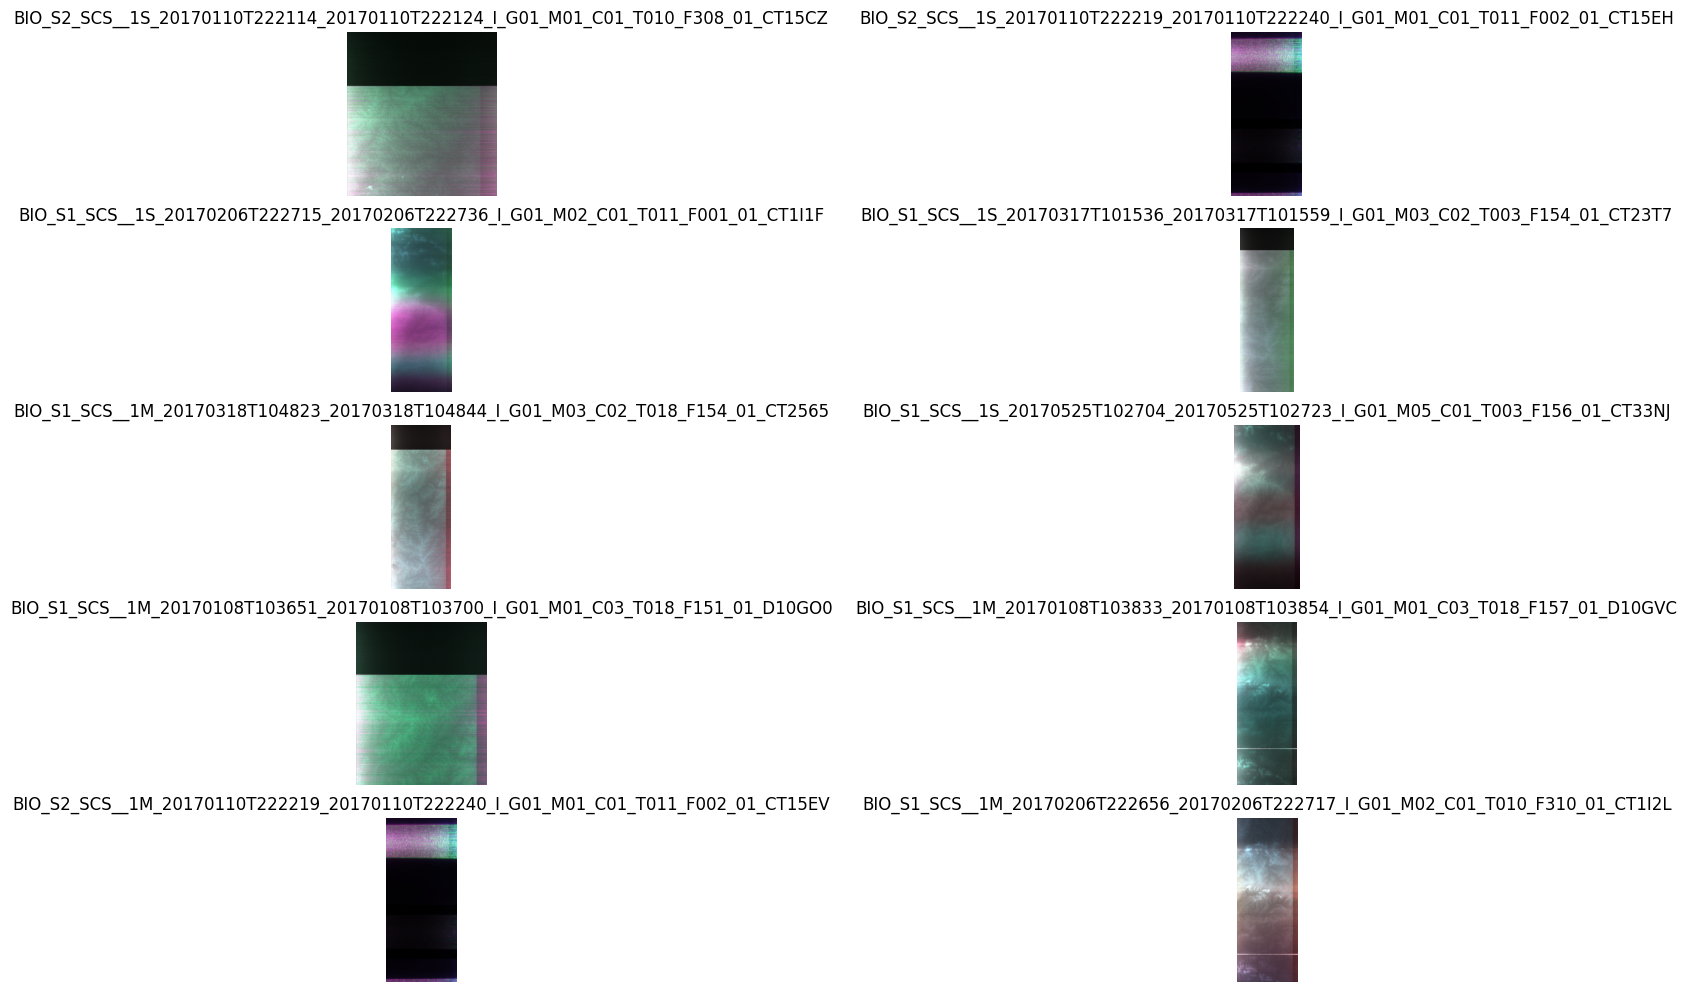

In [88]:
display_previews(results)

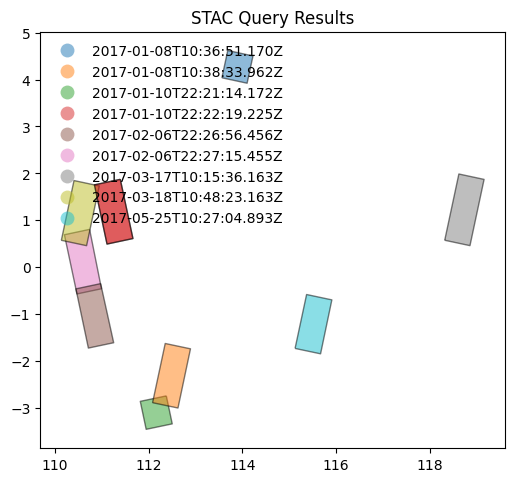

In [89]:
display_gdf_plot(results)

In [90]:
display_map(results)

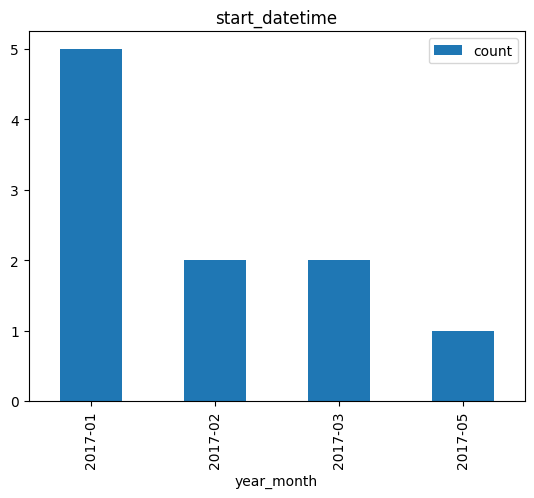

In [91]:
display_date_distribution(results, "start_datetime")

**Example: 2.4**  
>  Search granules by bounding box {bbox} [[RD11]](#RD11).  Geometry parameter is provided as Python tuple.

In [92]:
# x, y = (14.95, 37.74)   # Center point of query (Mount Etna)
x, y = (4.38, 51.25)   # Center point of query (Antwerp harbour) 

r = 0.1
box = (x - r, y - r, x + r, y + r)

from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items=10,
    collections=[COLLECTION_ID1],
    bbox = box
)

Same request using `curl`.

In [93]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "bbox=4.28,51.15,4.4799999999999995,51.35" \
	--data-urlencode "collections=PROBA.CHRIS.1A"
```


In [94]:
print(f"{results.matched()} items found.")

8 items found.


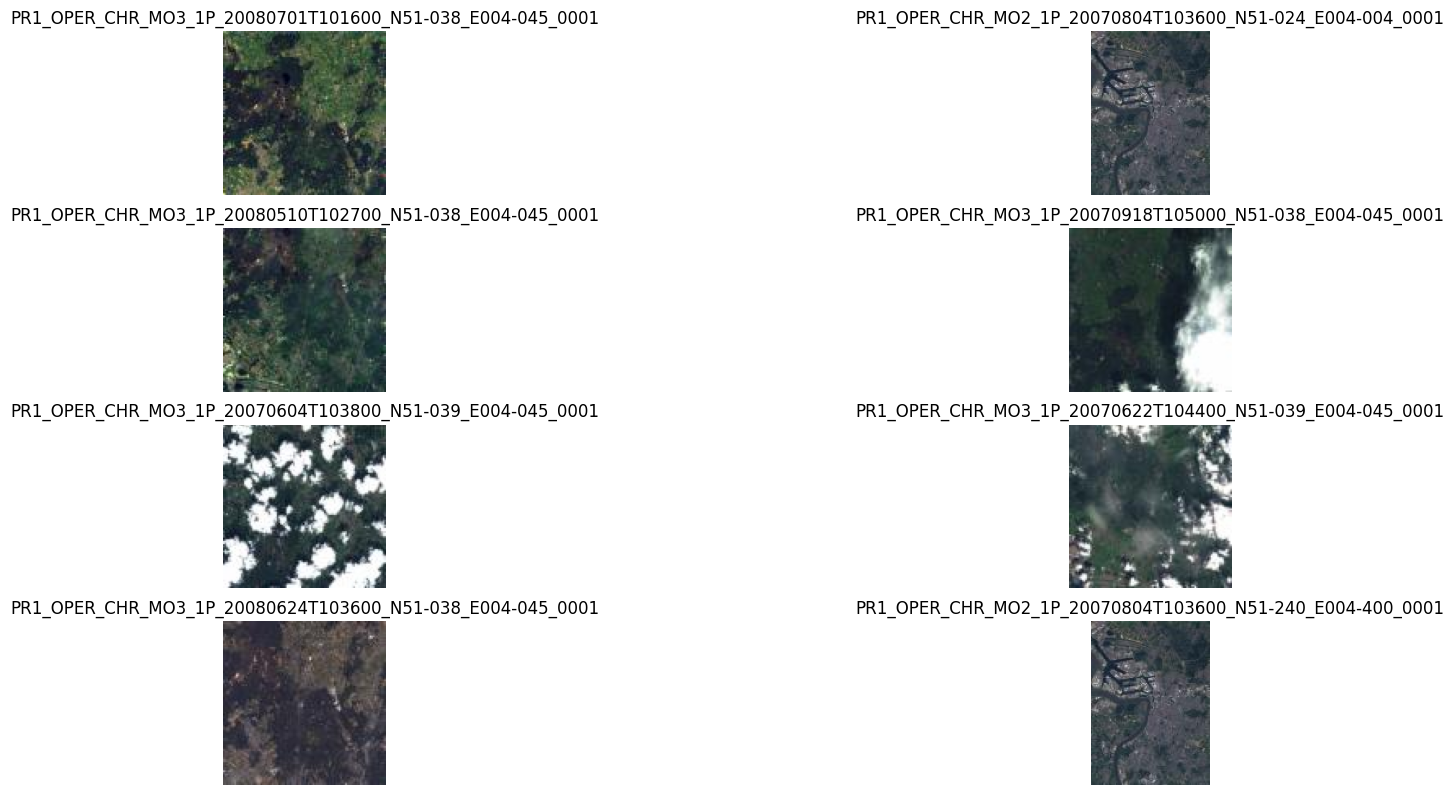

In [95]:
display_previews(results)

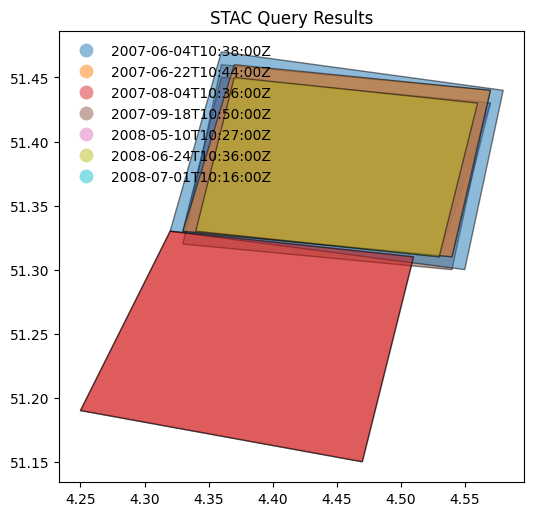

In [96]:
display_gdf_plot(results)

In [97]:
display_map(results)

```{index} double: STAC API ; datetime
```
```{index} double: pystac_client ; datetime
```

### Search by temporal extent

**Example: 2.6**  
>  Search granules by date range (datetime) [[RD01]](#RD01).  

In [98]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items = 50,
    collections=[COLLECTION_ID6_MAAP],
    datetime=['2017-01-01T00:00:00Z', '2017-05-30T00:00:00Z']
)

In [99]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "datetime=2017-01-01T00:00:00Z/2017-05-30T00:00:00Z" \
	--data-urlencode "collections=BiomassLevel1a"
```


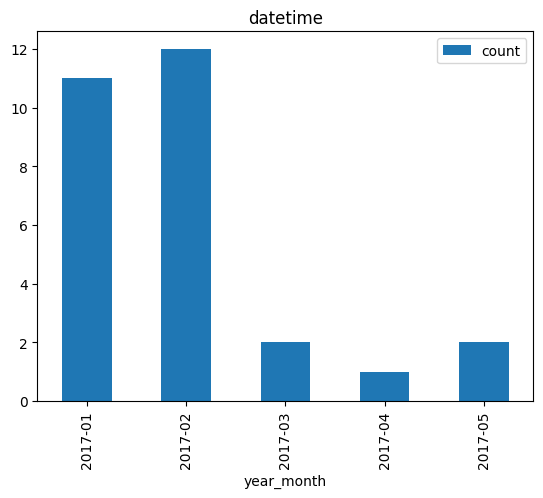

In [100]:
display_date_distribution(results, "datetime")

**Example: 2.7**  
>  Search granules by open-ended date range (datetime) [[RD01]](#RD01).  

In [101]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items = 50,
    collections=[COLLECTION_ID6_MAAP],
    datetime=['2017-02-01T00:00:00Z', None]
)

In [102]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "datetime=2017-02-01T00:00:00Z/.." \
	--data-urlencode "collections=BiomassLevel1a"
```


In [103]:
print(f"{results.matched()} items found.")

21 items found.


In [104]:
# keep id of first granule for future use below.
items = list(results.items())
granule_id1 = items[0].id

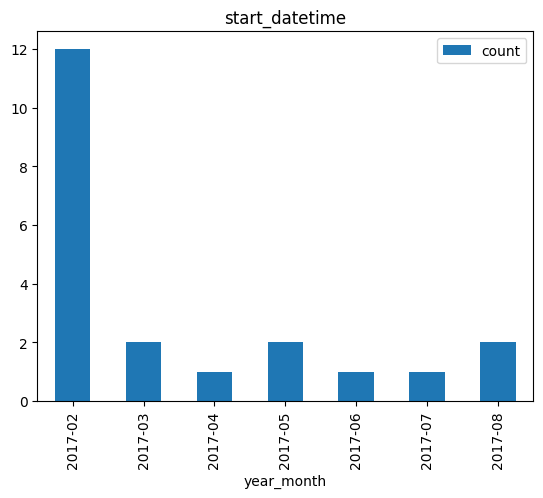

In [105]:
display_date_distribution(results)

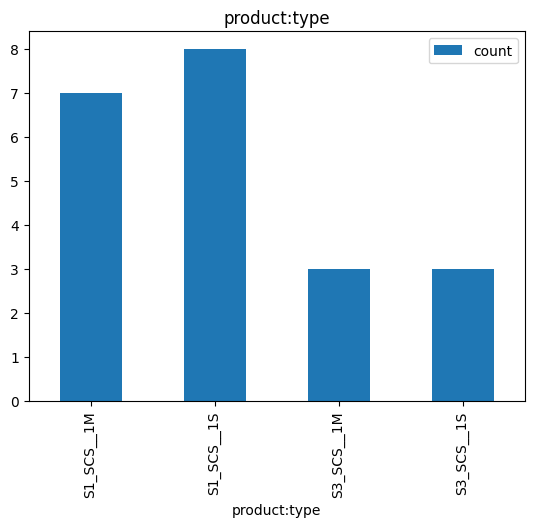

In [106]:
display_value_distribution(results, 'product:type')

```{index} double: STAC API ; ids
```

### Search by identifier


```{index} double: pystac_client ; ids
```
**Example: 2.8**  
>  Search granule by identifier (ids) [[RD01]](#RD01).  

In [107]:
granule_id1

'BIO_S1_SCS__1S_20170206T222715_20170206T222736_I_G01_M02_C01_T011_F001_01_CT1I1F'

In [108]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    collections=[COLLECTION_ID6_MAAP],
    ids=[granule_id1]
)

In [109]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "ids=BIO_S1_SCS__1S_20170206T222715_20170206T222736_I_G01_M02_C01_T011_F001_01_CT1I1F" \
	--data-urlencode "collections=BiomassLevel1a"
```


In [110]:
print(f"{results.matched()} items found.")
assert results.matched() == 1

# Convert STAC items into data frame
stac_json = results.item_collection_as_dict()
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
gdf.transpose()

1 items found.


0
geometry                   POLYGON ((110.73725 0.80407, 110.19941 0.68946...
time:published                                      2017-02-06T22:27:36.232Z
start_datetime                                      2017-02-06T22:27:15.455Z
end_datetime                                        2017-02-06T22:27:36.232Z
processing:facility                                              Biomass CPF
product:type                                                      S1_SCS__1S
sat:anx_datetime                                    2017-02-06T20:49:04.860Z
title                      BIO_S1_SCS__1S_20170206T222715_20170206T222736...
platform                                                             Biomass
datetime                                            2017-02-06T22:27:15.455Z
instruments                                                          [P-SAR]
constellation                                                        Biomass
sat:orbit_state                                                    ascending
eopf:datatake_id                                                     4413145
processing:software                        {'Biomass L1 Processor': '2.2.2'}
grid:code                                                           WRS-11-1
processing:level                                                          1A
proj:code                                                          EPSG:4326
version                                                                   01
sar:observation_direction                                               left
sar:polarizations                                           [HH, HV, VH, VV]
auth:schemes               {'http': {'type': 'http'}, 'oidc': {'openIdCon...
sar:instrument_mode                                                       SM
processing:datetime                                     2024-07-15T15:36:51Z
updated                                                 2025-03-10T12:18:07Z
sat:absolute_orbit                                                       538
product:acquisition_type                                             nominal

**Example: 2.9**  
>  Search granule by identifier (`ids`) [[RD01]](#RD01) without specifying collection. 

In [111]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    ids=[granule_id1]
)

In [112]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "ids=BIO_S1_SCS__1S_20170206T222715_20170206T222736_I_G01_M02_C01_T011_F001_01_CT1I1F"
```


In [113]:
print(f"{results.matched()} items found.")
assert results.matched() == 1

1 items found.


```{index} double: STAC API ; filter
```

### Search with filter

```{index} double: pystac_client ; filter
```

**Example: 2.10**  
>  Search granules with filter {filter} [[RD01]](#RD01).  Available filters are advertised in `Queryables` object at /collections/{id}/queryables.

In [114]:
url = URL_LANDING_PAGE + "collections/" + COLLECTION_ID6_MAAP + "/queryables"
url

'https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables'

In [115]:
# Get queryables response and list parameters alphabetically.
response = requests.get(url)
data = json.loads(response.text)    

jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

# df = pd.DataFrame(data['properties'].items(),columns=['key','value'])
# df['type'] = df.apply(lambda row : row['value']['type'], axis = 1)
# df

```json
{
   "$schema": "https://json-schema.org/draft/2019-09/schema",
   "description": "Queryable names for the STAC API Item Search filter.",
   "type": "object",
   "title": "Queryables for BiomassLevel1a collection",
   "properties": {
      "polarisationMode": {
         "description": "{eo:polarisationMode}",
         "title": "Polarisation mode",
         "type": "string",
         "enum": [
            "Q"
         ]
      },
      "acquisitionType": {
         "description": "{eo:acquisitionType}",
         "title": "Acquisition type",
         "type": "string",
         "enum": [
            "NOMINAL"
         ]
      },
      "processingDate": {
         "format": "date-time",
         "description": "{eo:processingDate}",
         "title": "Processing date",
         "type": "string"
      },
      "instrument": {
         "description": "{eo:instrument}",
         "title": "Instrument",
         "type": "string",
         "enum": [
            "P-SAR"
         ]
      },
      "platform": {
         "description": "{eo:platform}",
         "title": "Platform",
         "type": "string",
         "enum": [
            "Biomass"
         ]
      },
      "majorCycleID": {
         "description": "{eocat:majorCycleID}",
         "title": "Major cycle id",
         "type": "string",
         "enum": [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7"
         ]
      },
      "orbitNumber": {
         "description": "{eo:orbitNumber}",
         "title": "Orbit number",
         "type": "integer"
      },
      "productVersion": {
         "description": "{eo:productVersion}",
         "title": "Product version",
         "type": "string",
         "enum": [
            "01"
         ]
      },
      "processingLevel": {
         "description": "{eo:processingLevel}",
         "title": "Processing level",
         "type": "string",
         "enum": [
            "1A"
         ]
      },
      "productionStatus": {
         "description": "{eo:productionStatus}",
         "title": "Production status",
         "type": "string",
         "enum": [
            "ARCHIVED"
         ]
      },
      "processorName": {
         "description": "{eo:processorName}",
         "title": "Processor name",
         "type": "string",
         "enum": [
            "Biomass L1 Processor"
         ]
      },
      "startTimeFromAscendingNode": {
         "description": "{eo:startTimeFromAscendingNode}",
         "title": "Start time from ascending node",
         "type": "number"
      },
      "completionTimeFromAscendingNode": {
         "description": "{eo:completionTimeFromAscendingNode}",
         "title": "Completion time from ascending node",
         "type": "number"
      },
      "track": {
         "description": "{eo:track}",
         "title": "Track",
         "type": "string"
      },
      "antennaLookDirection": {
         "description": "{eo:antennaLookDirection}",
         "title": "Antenna look direction",
         "type": "string",
         "enum": [
            "LEFT",
            "RIGHT"
         ]
      },
      "productType": {
         "description": "{eo:productType}",
         "title": "Product type",
         "type": "string",
         "enum": [
            "S1_SCS__1M",
            "S1_SCS__1S",
            "S2_SCS__1M",
            "S2_SCS__1S",
            "S3_SCS__1M",
            "S3_SCS__1S"
         ]
      },
      "polarisationChannels": {
         "description": "{eo:polarisationChannels}",
         "title": "Polarisation channels",
         "type": "string",
         "enum": [
            "HH, HV, VH, VV"
         ]
      },
      "missionPhase": {
         "description": "{eocat:missionPhase}",
         "title": "Mission phase",
         "type": "string",
         "enum": [
            "INTERFEROMETRIC"
         ]
      },
      "repeatCycleID": {
         "description": "{eocat:repeatCycleID}",
         "title": "Repeat cycle id",
         "type": "string",
         "enum": [
            "1",
            "2",
            "3"
         ]
      },
      "swathIdentifier": {
         "description": "{eo:swathIdentifier}",
         "title": "Swath identifier",
         "type": "string",
         "enum": [
            "S1",
            "S2",
            "S3"
         ]
      },
      "dataTakeID": {
         "description": "{eocat:dataTakeID}",
         "title": "Data take id",
         "type": "integer"
      },
      "processingCenter": {
         "description": "{eo:processingCenter}",
         "title": "Processing center",
         "type": "string",
         "enum": [
            "Biomass CPF"
         ]
      },
      "modificationDate": {
         "format": "date-time",
         "description": "{eo:modificationDate}",
         "title": "Modification date",
         "type": "string"
      },
      "globalCoverageID": {
         "description": "{eocat:globalCoverageID}",
         "title": "Global coverage id",
         "type": "string",
         "enum": [
            "1"
         ]
      },
      "processingMode": {
         "description": "{eo:processingMode}",
         "title": "Processing mode",
         "type": "string",
         "enum": [
            "OPERATIONAL"
         ]
      },
      "sensorMode": {
         "description": "{eo:sensorMode}",
         "title": "Sensor mode",
         "type": "string",
         "enum": [
            "SM"
         ]
      },
      "orbitDirection": {
         "description": "{eo:orbitDirection}",
         "title": "Orbit direction",
         "type": "string",
         "enum": [
            "ASCENDING",
            "DESCENDING"
         ]
      },
      "frame": {
         "description": "{eo:frame}",
         "title": "Frame",
         "type": "string"
      }
   },
   "$id": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables"
}
```


In [116]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items=10,
    collections=[COLLECTION_ID6_MAAP],
    # bbox = [14.90, 37.700, 14.99, 37.780], # Mount Etna
    bbox = [108.0, -4.66, 119.0, 8.05], # Borneo
    # datetime=['2015-01-01T00:00:00Z', '2022-01-02T00:00:00Z'],
    datetime=['2017-01-01T00:00:00Z', '2017-05-30T00:00:00Z'],
    filter="productType='S1_SCS__1M' and instrument='P-SAR'"
)

Same request with `curl`.

In [117]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "bbox=108.0,-4.66,119.0,8.05" \
	--data-urlencode "datetime=2017-01-01T00:00:00Z/2017-05-30T00:00:00Z" \
	--data-urlencode "collections=BiomassLevel1a" \
	--data-urlencode "filter=productType='S1_SCS__1M' and instrument='P-SAR'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [118]:
print(f"{results.matched()} items found.")

8 items found.


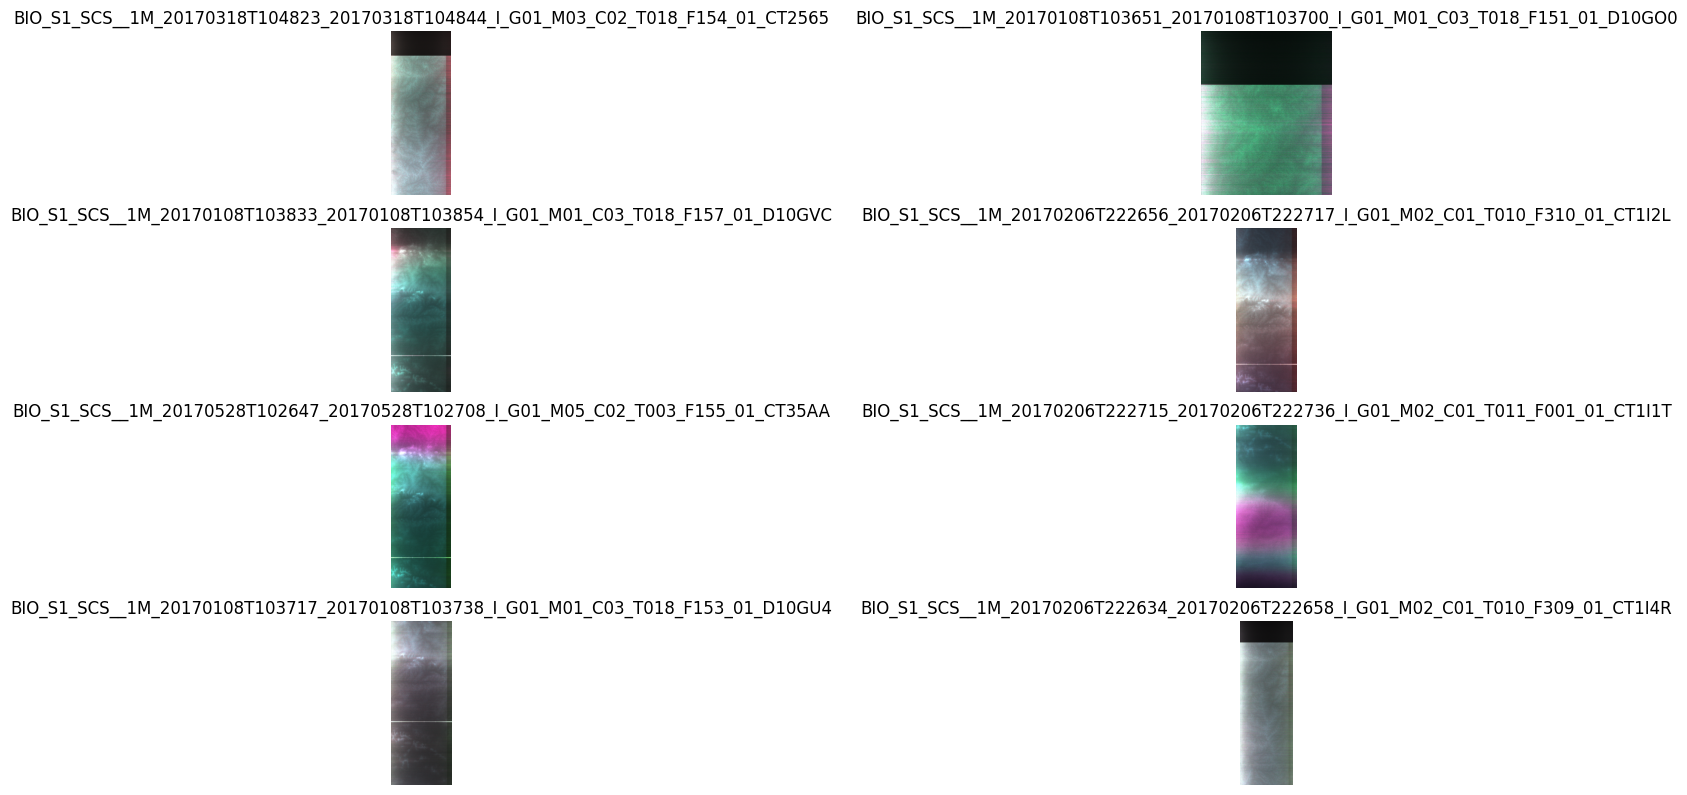

In [119]:
display_previews(results)

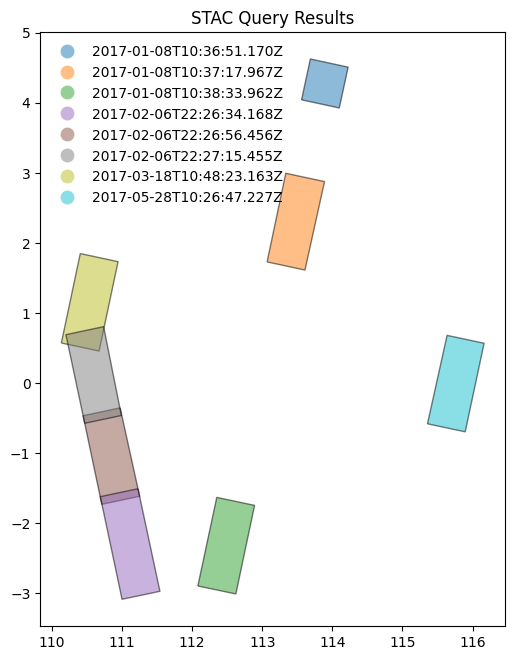

In [120]:
display_gdf_plot(results)

In [121]:
display_map(results)

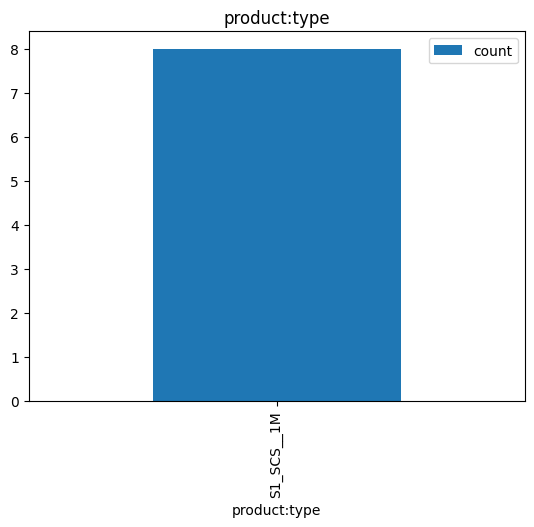

In [122]:
display_value_distribution(results, 'product:type')

### Search by cloud cover

```{index} double: filter ; cloudCover
```

**Example: 2.11**  
>  Search granules by cloudcover (`filter` and `cloudCover`) [[RD01]](#RD01).  Available filters are advertised in `Queryables` object at /collections/{id}/queryables.

In [123]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE)  

results = api.search(
    method = 'GET',   
    max_items=50,
    collections=[COLLECTION_ID3_CLOUDS],
    filter="cloudCover < 10"    
)

In [124]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "collections=IKONOS.ESA.archive" \
	--data-urlencode "filter=cloudCover < 10" \
	--data-urlencode "filter-lang=cql2-text"
```


In [125]:
print(f"{results.matched()} items found.")

246 items found.


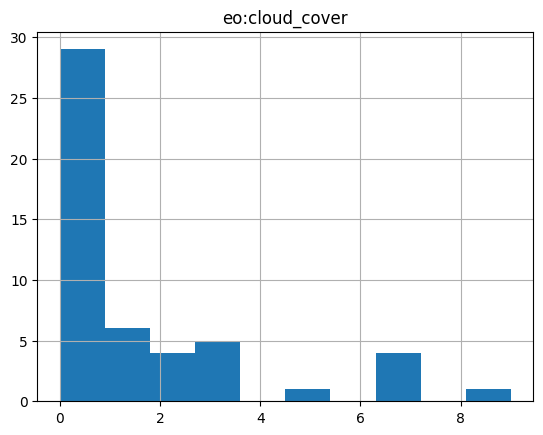

In [126]:
# Display cloud-cover values as histogram to show that range is taken into account
stac_json = results.item_collection_as_dict()
gdf = gpd.GeoDataFrame.from_features(stac_json)
try:
  _ = gdf[['title','eo:cloud_cover']].hist()
except:
  print("eo:cloud_cover information is not available.")

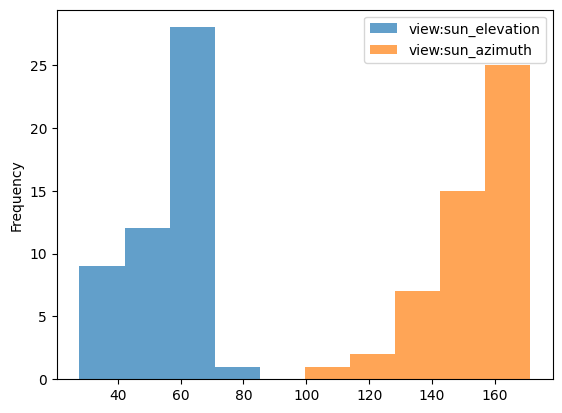

In [127]:
# fails if properties are not in the metadata.
try:
  # _ = gdf[['view:sun_elevation','view:incidence_angle','view:sun_azimuth']].plot.hist(alpha=0.7)
  _ = gdf[['view:sun_elevation','view:sun_azimuth']].plot.hist(alpha=0.7)
except:
  print("acquisition angle information is not available.")

In [128]:
# gdf

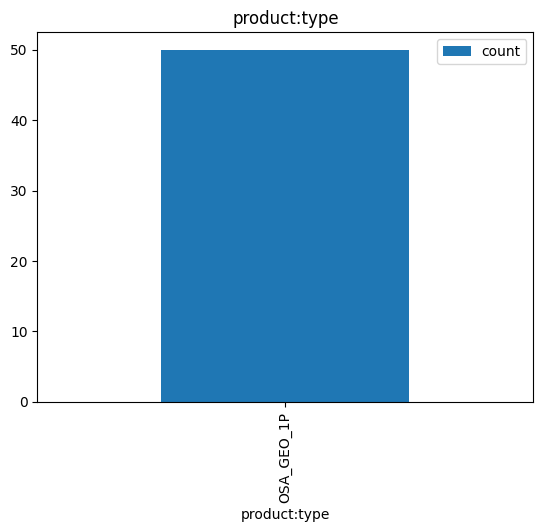

In [129]:
# display_value_distribution(results, 'sat:orbit_state')
display_value_distribution(results, 'product:type')

### Search by modification date

**Example: 2.12**  
>  Search granules by modificationDate (`filter` with `modificationDate`). 

In [130]:
api = Client.open(URL_LANDING_PAGE) 

results = api.search(    
    method = "GET",
    max_items = 10,
    filter="modificationDate > TIMESTAMP('2025-02-10T09:54:34.651Z')",
    collections = [ COLLECTION_ID6_MAAP ]
)

print(f"{results.matched()} granules found.")

32 granules found.


In [131]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "collections=BiomassLevel1a" \
	--data-urlencode "filter=modificationDate > TIMESTAMP('2025-02-10T09:54:34.651Z')" \
	--data-urlencode "filter-lang=cql2-text"
```


In [132]:
data = results.item_collection_as_dict()
df = pd.json_normalize(data, record_path=['features'])
df[['id', 'properties.updated', 'collection']]

id    properties.updated  \
0  BIO_S2_SCS__1S_20170110T222114_20170110T222124...  2025-03-10T12:08:08Z   
1  BIO_S2_SCS__1S_20170110T222219_20170110T222240...  2025-03-10T12:12:07Z   
2  BIO_S1_SCS__1S_20170206T222715_20170206T222736...  2025-03-10T12:18:07Z   
3  BIO_S1_SCS__1S_20170317T101536_20170317T101559...  2025-03-10T12:26:07Z   
4  BIO_S1_SCS__1M_20170318T104823_20170318T104844...  2025-03-10T12:26:07Z   
5  BIO_S1_SCS__1S_20170525T102704_20170525T102723...  2025-03-10T12:28:08Z   
6  BIO_S1_SCS__1M_20170108T103651_20170108T103700...  2025-03-10T12:02:07Z   
7  BIO_S1_SCS__1M_20170108T103833_20170108T103854...  2025-03-10T12:02:26Z   
8  BIO_S2_SCS__1M_20170110T222219_20170110T222240...  2025-03-10T12:08:07Z   
9  BIO_S1_SCS__1M_20170206T222656_20170206T222717...  2025-03-10T12:12:08Z   

       collection  
0  BiomassLevel1a  
1  BiomassLevel1a  
2  BiomassLevel1a  
3  BiomassLevel1a  
4  BiomassLevel1a  
5  BiomassLevel1a  
6  BiomassLevel1a  
7  BiomassLevel1a  
8  BiomassLevel1a  
9  BiomassLevel1a

### Search multiple collections

**Example: 2.13**  
>  Search granules in multiple collections {collections} [[RD01]](#RD01).  

In [133]:

api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'GET',   
    max_items=10,
    collections=[COLLECTION_ID6_MAAP, COLLECTION_ID9_MAAP],
    bbox = [108.0, -4.66, 119.0, 8.05] # Borneo
    # bbox = [13.90, 36.700, 15.99, 38.780], # Mount Etna (large)
)

In [134]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "bbox=108.0,-4.66,119.0,8.05" \
	--data-urlencode "collections=BiomassLevel1a,BiomassLevel2a"
```


In [135]:
print(f"{results.matched()} items found.")

41 items found.


In [136]:
results = api.search(
    method = 'GET',   
    max_items=10,
    collections=[COLLECTION_ID9_MAAP],
    bbox = [108.0, -4.66, 119.0, 8.05] # Borneo
    # bbox = [13.90, 36.700, 15.99, 38.780], # Mount Etna (large)
)

In [137]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "bbox=108.0,-4.66,119.0,8.05" \
	--data-urlencode "collections=BiomassLevel2a"
```


In [138]:
print(f"{results.matched()} items found.")

9 items found.


**Example: 2.13**  
>  Search granules in multiple collections {collections} [[RD01]](#RD01) using `POST`. 

In [139]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE) 

results = api.search(
    method = 'POST',    
    max_items=50,
    collections=[COLLECTION_ID6_MAAP, COLLECTION_ID9_MAAP],
    bbox = [108.0, -4.66, 119.0, 8.05] # Borneo
    # bbox = [13.90, 36.700, 15.99, 38.780] # Mount Etna (large)
)

In [140]:
curl_str = curl_command(results.url_with_parameters(),'POST')
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X POST https://catalog.maap.eo.esa.int/catalogue/search \
	--header 'Content-Type: application/json' \
	--data-raw '{
		"bbox": "108.0,-4.66,119.0,8.05",
		"collections": ["BiomassLevel1a", "BiomassLevel2a"]
	}'
```


In [141]:
print(f"{results.matched()} items found.")

41 items found.


## Granule properties

Granules are returned via `item` links in the Catalog or Collection objects, or via the STAC API (Feature).
 An item is a GeoJSON `Feature` and the encoding is derived from the original OGC 17-003r2 encoding 
 according to a [documented mapping](https://github.com/stac-utils/stac-crosswalks/tree/master/OGC_17-003r2).
     
 The properties available include attributes from STAC extensions as well:    
  
 * [Item fields](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#item-fields) 
 * [Common metadata elements](https://github.com/radiantearth/stac-spec/blob/master/item-spec/common-metadata.md) 
 * [EO Extension](https://github.com/stac-extensions/eo)
 * [SAR Extension](https://github.com/stac-extensions/sar)
 * [SAT Extension](https://github.com/stac-extensions/sat)
 * [Scientific Extension](https://github.com/stac-extensions/scientific)   
 * [Version Extension](https://github.com/stac-extensions/version)
 * [View Extension](https://github.com/stac-extensions/view)
 * [Projection Extension](https://github.com/stac-extensions/projection)
 * [Timestamps Extension](https://github.com/stac-extensions/timestamps)
 * [Landsat Extension](https://landsat.usgs.gov/stac/landsat-extension/schema.json)   



```{index} double: pystac_client ; assets
```
```{index} double: STAC API ; assets 
```
```{index} double: STAC API ; thumbnail 
```
```{index} double: STAC API ; data 
```
```{index} double: STAC API ; metadata 
```
```{index} double: assets ; OGC 10-157r4 
```
```{index} double: assets ; OGC 17-003r2 
```

### Assets

Granules provide access to a dictionary with `assets`.  The `roles` attribute indicates the purpose of the asset. The `href` attribute provides the URL to access the asset.  Granule assets include `thumbnail` (when available), a `data` download link (equivalent to the rel=`enclosure`), and various `metadata` formats.

The table below list some frequently used `metadata` formats and their corresponding media type (`type`).

| Format                   | type |   
| --------                   | --------- | 
| [ISO19139](https://www.iso.org/standard/32557.html)        | application/vnd.iso.19139+xml |  
| [ISO19139-2](https://www.iso.org/standard/57104.html)      | application/vnd.iso.19139-2+xml | 
| [ISO19115-3](https://www.iso.org/standard/32579.html)      | application/vnd.iso.19115-3+xml | 
| [OGC 10-157r4](https://docs.opengeospatial.org/is/10-157r4/10-157r4.html)  | application/gml+xml;profile=http://www.opengis.net/spec/EOMPOM/1.1  |
| [OGC 17-003r2](https://docs.opengeospatial.org/is/17-003r2/17-003r2.html)  | application/geo+json;profile=http://www.opengis.net/spec/eo-geojson/1.0  |

In [142]:
# Show assets of first search result (GeoJSON)
data = results.item_collection_as_dict()
jstr = json.dumps(data['features'][1]['assets'], indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "quicklook_1": {
      "roles": [
         "overview"
      ],
      "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/10/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH/preview/bio_s2_scs__1s_20170110t222219_20170110t222240_i_g01_m01_c01_t011_f002_ql.png",
      "type": "image/png",
      "title": "preview"
   },
   "thumbnail": {
      "roles": [
         "thumbnail"
      ],
      "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/10/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH/public/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH.BI.PNG",
      "type": "image/png",
      "title": "Preview"
   },
   "product": {
      "file:local_path": "BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH.zip",
      "alternate:name": "HTTPS",
      "roles": [
         "data",
         "metadata",
         "archive"
      ],
      "href": "https://catalog.maap.eo.esa.int/data/zipper/biomass-pdgs-01/BiomassLevel1a/2017/01/10/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH",
      "auth:refs": [
         "oidc"
      ],
      "title": "Zipped product",
      "type": "application/zip"
   },
   "metadata_ogc_10_157r4": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH?httpAccept=application/gml%2Bxml&recordSchema=om",
      "title": "OGC 10-157r4 metadata",
      "type": "application/gml+xml;profile=\"http://www.opengis.net/spec/EOMPOM/1.1\""
   },
   "metadata_ogc_17_003r2": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH?mode=owc",
      "title": "OGC 17-003r2 metadata",
      "type": "application/geo+json;profile=\"http://www.opengis.net/spec/eo-geojson/1.0\""
   },
   "metadata_iso_19139": {
      "roles": [
         "metadata"
      ],
      "href": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/items/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH?httpAccept=application/vnd.iso.19139%2Bxml",
      "title": "ISO 19139 metadata",
      "type": "application/vnd.iso.19139+xml"
   },
   "quicklook": {
      "roles": [
         "overview"
      ],
      "href": "https://catalog.maap.eo.esa.int/data/biomass-pdgs-01/BiomassLevel1a/2017/01/10/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH/BIO_S2_SCS__1S_20170110T222219_20170110T222240_I_G01_M01_C01_T011_F002_01_CT15EH/preview/bio_s2_scs__1s_20170110t222219_20170110t222240_i_g01_m01_c01_t011_f002_map.kmz",
      "type": "application/vnd.google-earth.kmz",
      "title": "preview"
   }
}
```


In [143]:
df = pd.DataFrame(columns=['roles', 'title', 'type'])
    
# Display assets belonging to first item in results
for item in results.items():
    assets = item.assets
    for key in assets: 
        try: 
            ndf = pd.DataFrame({ 
                'roles': str(assets[key].roles), 
                'type': assets[key].media_type, 
                'title': assets[key].title, 
                # 'href': assets[key].href  
            }, index = [0])
            df = pd.concat([df, ndf], ignore_index=True)
        except:
            pass
    break
df

roles                  title  \
0                     ['overview']                preview   
1                    ['thumbnail']                Preview   
2  ['data', 'metadata', 'archive']         Zipped product   
3                     ['metadata']  OGC 10-157r4 metadata   
4                     ['metadata']  OGC 17-003r2 metadata   
5                     ['metadata']     ISO 19139 metadata   
6                     ['overview']                preview   

                                                type  
0                                          image/png  
1                                          image/png  
2                                    application/zip  
3  application/gml+xml;profile="http://www.opengi...  
4  application/geo+json;profile="http://www.openg...  
5                      application/vnd.iso.19139+xml  
6                   application/vnd.google-earth.kmz

## Advanced topics

```{index} double: STAC API ; conformsTo
```

### Conformance classes

The conformance classes supported by the STAC interface are advertised in the `conformsTo` property of the landing page.

In [144]:
response = requests.get(URL_LANDING_PAGE)

data = json.loads(response.text)
jstr = json.dumps(data['conformsTo'], indent=3)
md("```json\n" + jstr + "\n```\n")

```json
[
   "http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core",
   "http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30",
   "http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson",
   "http://www.opengis.net/spec/ogcapi_common-2/1.0/conf/collections",
   "http://www.opengis.net/spec/ogcapi-common-2/1.0/conf/simple-query",
   "http://www.opengis.net/spec/ogcapi-records-1/1.0/req/cql-filter",
   "http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/features-filter",
   "http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter",
   "https://api.stacspec.org/v1.0.0/core",
   "https://api.stacspec.org/v1.0.0/ogcapi-features",
   "https://api.stacspec.org/v1.0.0/collections",
   "https://api.stacspec.org/v1.0.0-rc.1/collection-search",
   "https://api.stacspec.org/v1.0.0-rc.1/collection-search#filter",
   "https://api.stacspec.org/v1.0.0-rc.1/collection-search#free-text",
   "https://api.stacspec.org/v1.0.0/item-search",
   "https://api.stacspec.org/v1.0.0-rc.3/item-search#filter",
   "http://www.opengis.net/spec/cql2/1.0/conf/cql2-text",
   "http://www.opengis.net/spec/cql2/1.0/conf/basic-cql2"
]
```


### Additional search parameters


In [145]:
md(f'Additional search parameters beyond the STAC search parameters can be used to filter collection search results. The available parameters for collection search are advertised at {URL_LANDING_PAGE + "collections/queryables"} and represented as a JSON Schema.')

Additional search parameters beyond the STAC search parameters can be used to filter collection search results. The available parameters for collection search are advertised at https://catalog.maap.eo.esa.int/catalogue/collections/queryables and represented as a JSON Schema.

In [146]:
URL_QUERYABLES = URL_LANDING_PAGE + 'collections/queryables'

In [147]:
curl_str = curl_command(URL_QUERYABLES)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections/queryables
```


In [148]:
response = requests.get(URL_QUERYABLES)   
data = json.loads(response.text)    
df = pd.DataFrame(data['properties'].items(),columns=['key','value'])
df['type'] = df.apply(lambda row : row['value']['type'], axis = 1)
df['format'] = df.apply(lambda row : row['value']['format'] if 'format' in row['value'] else '-' , axis = 1)
df.drop('value',axis=1).sort_values(by=['key'])

key    type     format
12      classifiedAs  string        uri
11               doi  string          -
2         instrument  string          -
7   modificationDate  string  date-time
10          offering  string          -
6   organisationName  string          -
4    otherConstraint  string          -
1   parentIdentifier  string          -
5           platform  string          -
8    processingLevel  string          -
0              query  string          -
3              title  string          -
9      useLimitation  string          -

In [149]:
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "$schema": "https://json-schema.org/draft/2019-09/schema",
   "description": "Queryable names for the STAC API Collection Search filter.",
   "type": "object",
   "title": "Queryables for the STAC API",
   "properties": {
      "query": {
         "description": "{os:searchTerms}",
         "title": "Query",
         "type": "string"
      },
      "parentIdentifier": {
         "description": "{eo:parentIdentifier}",
         "title": "Parent identifier",
         "type": "string",
         "enum": [
            "EOP:ESA:EARTH-ONLINE",
            "EOP:ESA:MAAP",
            "EOP:EU:DATASPACE",
            "EOP:NASA:CMR",
            "EOP:STFC:CEDA-CCI"
         ]
      },
      "instrument": {
         "description": "{eo:instrument}",
         "title": "Instrument",
         "type": "string",
         "enum": [
            "AATSR",
            "ALADIN",
            "AMI/SAR",
            "ASAR",
            "ATLID",
            "ATSR-1",
            "ATSR-2",
            "AVHRR",
            "AVNIR-2",
            "BBR",
            "BGI",
            "CHRIS",
            "CPR",
            "Cameras",
            "EGG",
            "EOC",
            "ETM",
            "GEDI",
            "GIS",
            "GOME",
            "HRC",
            "HRG",
            "HRS",
            "HRV",
            "HRVIR",
            "HiRAIS",
            "HiRI",
            "Imaging Radars",
            "Imaging Spectrometers/Radiometers",
            "LISS-3",
            "MERIS",
            "MESSR",
            "MGM",
            "MIPAS",
            "MIRAS",
            "MSC",
            "MSI",
            "MSS",
            "MWR",
            "NAOMI",
            "OCM-2",
            "OLI",
            "OPS",
            "OSA",
            "P-SAR",
            "PALSAR",
            "PAN",
            "PAZ-SAR",
            "PRISM",
            "PlanetScope Camera",
            "RA",
            "RA-2",
            "RBV",
            "SAR",
            "SCIAMACHY",
            "SIRAL",
            "SLIM6",
            "SSTI",
            "STR",
            "SkySat Camera",
            "SpaceView-110",
            "TDX-1",
            "TIRS",
            "TM",
            "TSX-1",
            "VTIR",
            "WV110",
            "WV60",
            "X-SAR"
         ]
      },
      "title": {
         "description": "{dc:title}",
         "title": "Title",
         "type": "string"
      },
      "otherConstraint": {
         "description": "{eo:otherConstraint}",
         "title": "Other constraint",
         "type": "string"
      },
      "platform": {
         "description": "{eo:platform}",
         "title": "Platform",
         "type": "string",
         "enum": [
            "ALOS-1",
            "Aeolus",
            "Beijing-1",
            "Biomass",
            "COSMO-SkyMed",
            "CryoSat-2",
            "ERS-1",
            "ERS-2",
            "EarthCARE",
            "Envisat",
            "GEOSAT-1",
            "GEOSAT-2",
            "GOCE",
            "GeoEye-1",
            "ICESat-2",
            "ICEYE",
            "IKONOS-2",
            "IRS-1C",
            "IRS-1D",
            "IRS-P5",
            "IRS-P6",
            "ISS",
            "JERS-1",
            "KOMPSAT-1",
            "KOMPSAT-2",
            "Landsat-1",
            "Landsat-2",
            "Landsat-3",
            "Landsat-4",
            "Landsat-5",
            "Landsat-7",
            "Landsat-8",
            "MOS-1A",
            "MOS-1B",
            "Metop-A",
            "Metop-B",
            "NOAA POES",
            "NigeriaSat-1",
            "OceanSat-2",
            "PAZ",
            "PROBA-1",
            "PlanetScope",
            "Pleiades",
            "QuickBird-2",
            "RADARSAT-1",
            "RapidEye",
            "SMOS",
            "SPOT 1",
            "SPOT 2",
            "SPOT 3",
            "SPOT 4",
            "SPOT 5",
            "SPOT 6",
            "SPOT 7",
            "Seasat",
            "Sentinel-1",
            "Sentinel-2",
            "SkySat",
            "TanDEM-X",
            "TerraSAR-X",
            "UAV",
            "UK-DMC-1",
            "WorldView-1",
            "WorldView-2",
            "WorldView-3",
            "WorldView-4"
         ]
      },
      "organisationName": {
         "description": "{eo:organisationName}",
         "title": "Organisation name",
         "type": "string",
         "enum": [
            "CEDA",
            "CMR",
            "ESA/ESRIN",
            "NASA NSIDC DAAC",
            "ORNL_DAAC"
         ]
      },
      "modificationDate": {
         "format": "date-time",
         "description": "{eo:modificationDate}",
         "title": "Modification date",
         "type": "string"
      },
      "processingLevel": {
         "description": "{eo:processingLevel}",
         "title": "Processing level",
         "type": "string",
         "enum": [
            "1a",
            "level 0",
            "level 1",
            "level 1.5",
            "level 1a",
            "level 1b",
            "level 1c",
            "level 1d",
            "level 1g",
            "level 1gt",
            "level 1r",
            "level 1t",
            "level 2",
            "level 2a",
            "level 2b",
            "level 2c",
            "level 3",
            "level 3a",
            "level 3b",
            "level 4",
            "multiple"
         ]
      },
      "useLimitation": {
         "description": "{eo:useLimitation}",
         "title": "Use limitation",
         "type": "string",
         "enum": [
            "access to and use of biomass products are governed by the esa's data policy and require acceptance of the specific terms & conditions. by accessing biomass products, users inherently acknowledge and agree to these terms.",
            "data service request",
            "eo sign in authentication (open)",
            "eo sign in authentication",
            "fast registration with approval (restrained)",
            "fast registration with approval",
            "fast registration with immediate access",
            "license url for data use policy https://science.nasa.gov/earth-science/earth-science-data/data-information-policy",
            "license url for data use policy https://www.earthdata.nasa.gov/engage/open-data-services-software-policies/data-use-guidance",
            "open access",
            "project proposal (restrained)",
            "restrained data",
            "under the following licence https://artefacts.ceda.ac.uk/licences/specific_licences/esacci_biomass_terms_and_conditions_v2.pdf, appropriate use of these data may fall under any use. this message is intended as guidance, always read the full licence. when using these data you must cite them correctly using the citation given on the ceda data catalogue record. https://artefacts.ceda.ac.uk/licences/specific_licences/esacci_biomass_terms_and_conditions_v2.pdf",
            "utilisation of this data is subject to esa's earth observation terms and conditions https://earth.esa.int/eogateway/documents/20142/1560778/esa-third-party-missions-terms-and-conditions.pdf"
         ]
      },
      "offering": {
         "description": "{eo:offering}",
         "title": "Offering",
         "type": "string",
         "enum": [
            "describecoverage",
            "getcapabilities",
            "getcoverage",
            "getmap",
            "wcs",
            "wms"
         ]
      },
      "doi": {
         "description": "{eo:doi}",
         "title": "Doi",
         "type": "string",
         "enum": [
            "10.3334/ornldaac/1577",
            "10.3334/ornldaac/1923",
            "10.3334/ornldaac/1952",
            "10.3334/ornldaac/2028",
            "10.3334/ornldaac/2056",
            "10.3334/ornldaac/2180",
            "10.3334/ornldaac/2186",
            "10.3334/ornldaac/2236",
            "10.3334/ornldaac/2251",
            "10.3334/ornldaac/2294",
            "10.3334/ornldaac/2298",
            "10.3334/ornldaac/2321",
            "10.3334/ornldaac/2338",
            "10.3334/ornldaac/2339",
            "10.5270/al1-5e400fd",
            "10.5270/al1-a06d3ac",
            "10.5270/al1-b459f4e",
            "10.5270/al1-d9cfa6d",
            "10.5270/al1-d9d4874",
            "10.5270/avh-f1i8784",
            "10.5270/cr2-120cf4c",
            "10.5270/dm1-w9tup3r",
            "10.5270/en1-4c37krv",
            "10.5270/en1-61d6y63",
            "10.5270/en1-77pi5sd",
            "10.5270/en1-88oasur",
            "10.5270/en1-a1rc3jf",
            "10.5270/en1-c8hgqx4",
            "10.5270/en1-cu4a5e3",
            "10.5270/en1-d9ryw7t",
            "10.5270/en1-eqvj8vs",
            "10.5270/en1-opsw96m",
            "10.5270/en1-q74d24h",
            "10.5270/en1-ttqbj6p",
            "10.5270/en1-u55aesn",
            "10.5270/en1-ueksx4q",
            "10.5270/en1-vqoj1gs",
            "10.5270/en1-w5xkqmx",
            "10.5270/en1-x542no0",
            "10.5270/ers-0p2cu8d",
            "10.5270/ers-7c3qhyo",
            "10.5270/ers-suu0xfp",
            "10.5270/esa-02d6cbf",
            "10.5270/esa-2d07033",
            "10.5270/esa-2eb13ab",
            "10.5270/esa-4427c33",
            "10.5270/esa-6mxo3sr",
            "10.5270/esa-79a176b",
            "10.5270/esa-7c37033",
            "10.5270/esa-7nc8pjp",
            "10.5270/esa-852456e",
            "10.5270/esa-86e26dc",
            "10.5270/esa-8sfucze",
            "10.5270/esa-8xb8scs",
            "10.5270/esa-a36265c",
            "10.5270/esa-a681fe7",
            "10.5270/esa-c26d993",
            "10.5270/esa-d69ulft",
            "10.5270/esa-e3e68ff",
            "10.5270/esa-ht6sxz7",
            "10.5270/esa-iboli84",
            "10.5270/esa-j340roh",
            "10.5270/esa-jfhe2um",
            "10.5270/esa-l8g67jw",
            "10.5270/esa-otce9j2",
            "10.5270/esa-qoe849q",
            "10.5270/ik2-5dwhs28",
            "10.5270/je1-408s1ur",
            "10.5270/je1-64xxf7c",
            "10.5270/je1-cerzmcu",
            "10.5270/ko2-2ijzzay",
            "10.5270/qb2-ftu9xmh",
            "10.5270/se1-99j66hv",
            "10.5285/bf535053562141c6bb7ad831f5998d77",
            "10.57780/al1-36b29e9",
            "10.57780/al1-5f3877f",
            "10.57780/en1-2d5de29",
            "10.57780/esa-38f62f7",
            "10.57780/esa-5018efb",
            "10.57780/esa-53b8e3f",
            "10.57780/esa-6fc121d",
            "10.57780/esa-80e19f0",
            "10.57780/esa-b667eb7",
            "10.57780/esa-c9d5673",
            "10.57780/sm1-4f787c3",
            "10.57780/sm1-5ebe10b",
            "10.57780/sm1-857c3d7 10.57780/sm1-e20cf57 10.57780/sm1-294cb1b",
            "10.57780/sm1-fbf89e0"
         ]
      },
      "classifiedAs": {
         "format": "uri",
         "description": "{semantic:classifiedAs}",
         "title": "Classified as",
         "type": "string"
      }
   },
   "$id": "https://catalog.maap.eo.esa.int/catalogue/collections/queryables"
}
```


Additional search parameters beyond the STAC search parameters can be used to filter granule search results.  The available parameters for granule search are advertised for each individual collection and represented as a JSON Schema.

In [150]:
URL_COLLECTION_QUERYABLES = URL_LANDING_PAGE + 'collections/' + COLLECTION_ID6_MAAP + '/queryables'

md(f"For example, the collection `{COLLECTION_ID6_MAAP}`, advertises its search parameters \
at {URL_COLLECTION_QUERYABLES} in JSON Schema format. Therefore, the following parameters can be used within a filter expression.")

For example, the collection `BiomassLevel1a`, advertises its search parameters at https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables in JSON Schema format. Therefore, the following parameters can be used within a filter expression.

Get filter parameters for granule search

In [151]:
curl_str = curl_command(URL_COLLECTION_QUERYABLES)
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables
```


In [152]:
response = requests.get(URL_COLLECTION_QUERYABLES)   
data = json.loads(response.text)    
df = pd.DataFrame(data['properties'].items(),columns=['key','value'])
df['type'] = df.apply(lambda row : row['value']['type'], axis = 1)
df['format'] = df.apply(lambda row : row['value']['format'] if 'format' in row['value'] else '-' , axis = 1)
df.drop('value',axis=1).sort_values(by=['key'])

key     type     format
1                   acquisitionType   string          -
14             antennaLookDirection   string          -
12  completionTimeFromAscendingNode   number          -
20                       dataTakeID  integer          -
27                            frame   string          -
23                 globalCoverageID   string          -
3                        instrument   string          -
5                      majorCycleID   string          -
17                     missionPhase   string          -
22                 modificationDate   string  date-time
26                   orbitDirection   string          -
6                       orbitNumber  integer          -
4                          platform   string          -
16             polarisationChannels   string          -
0                  polarisationMode   string          -
21                 processingCenter   string          -
2                    processingDate   string  date-time
8                   processingLevel   string          -
24                   processingMode   string          -
10                    processorName   string          -
15                      productType   string          -
7                    productVersion   string          -
9                  productionStatus   string          -
18                    repeatCycleID   string          -
25                       sensorMode   string          -
11       startTimeFromAscendingNode   number          -
19                  swathIdentifier   string          -
13                            track   string          -

In [153]:
jstr = json.dumps(data, indent=3)
md("```json\n" + jstr + "\n```\n")

```json
{
   "$schema": "https://json-schema.org/draft/2019-09/schema",
   "description": "Queryable names for the STAC API Item Search filter.",
   "type": "object",
   "title": "Queryables for BiomassLevel1a collection",
   "properties": {
      "polarisationMode": {
         "description": "{eo:polarisationMode}",
         "title": "Polarisation mode",
         "type": "string",
         "enum": [
            "Q"
         ]
      },
      "acquisitionType": {
         "description": "{eo:acquisitionType}",
         "title": "Acquisition type",
         "type": "string",
         "enum": [
            "NOMINAL"
         ]
      },
      "processingDate": {
         "format": "date-time",
         "description": "{eo:processingDate}",
         "title": "Processing date",
         "type": "string"
      },
      "instrument": {
         "description": "{eo:instrument}",
         "title": "Instrument",
         "type": "string",
         "enum": [
            "P-SAR"
         ]
      },
      "platform": {
         "description": "{eo:platform}",
         "title": "Platform",
         "type": "string",
         "enum": [
            "Biomass"
         ]
      },
      "majorCycleID": {
         "description": "{eocat:majorCycleID}",
         "title": "Major cycle id",
         "type": "string",
         "enum": [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7"
         ]
      },
      "orbitNumber": {
         "description": "{eo:orbitNumber}",
         "title": "Orbit number",
         "type": "integer"
      },
      "productVersion": {
         "description": "{eo:productVersion}",
         "title": "Product version",
         "type": "string",
         "enum": [
            "01"
         ]
      },
      "processingLevel": {
         "description": "{eo:processingLevel}",
         "title": "Processing level",
         "type": "string",
         "enum": [
            "1A"
         ]
      },
      "productionStatus": {
         "description": "{eo:productionStatus}",
         "title": "Production status",
         "type": "string",
         "enum": [
            "ARCHIVED"
         ]
      },
      "processorName": {
         "description": "{eo:processorName}",
         "title": "Processor name",
         "type": "string",
         "enum": [
            "Biomass L1 Processor"
         ]
      },
      "startTimeFromAscendingNode": {
         "description": "{eo:startTimeFromAscendingNode}",
         "title": "Start time from ascending node",
         "type": "number"
      },
      "completionTimeFromAscendingNode": {
         "description": "{eo:completionTimeFromAscendingNode}",
         "title": "Completion time from ascending node",
         "type": "number"
      },
      "track": {
         "description": "{eo:track}",
         "title": "Track",
         "type": "string"
      },
      "antennaLookDirection": {
         "description": "{eo:antennaLookDirection}",
         "title": "Antenna look direction",
         "type": "string",
         "enum": [
            "LEFT",
            "RIGHT"
         ]
      },
      "productType": {
         "description": "{eo:productType}",
         "title": "Product type",
         "type": "string",
         "enum": [
            "S1_SCS__1M",
            "S1_SCS__1S",
            "S2_SCS__1M",
            "S2_SCS__1S",
            "S3_SCS__1M",
            "S3_SCS__1S"
         ]
      },
      "polarisationChannels": {
         "description": "{eo:polarisationChannels}",
         "title": "Polarisation channels",
         "type": "string",
         "enum": [
            "HH, HV, VH, VV"
         ]
      },
      "missionPhase": {
         "description": "{eocat:missionPhase}",
         "title": "Mission phase",
         "type": "string",
         "enum": [
            "INTERFEROMETRIC"
         ]
      },
      "repeatCycleID": {
         "description": "{eocat:repeatCycleID}",
         "title": "Repeat cycle id",
         "type": "string",
         "enum": [
            "1",
            "2",
            "3"
         ]
      },
      "swathIdentifier": {
         "description": "{eo:swathIdentifier}",
         "title": "Swath identifier",
         "type": "string",
         "enum": [
            "S1",
            "S2",
            "S3"
         ]
      },
      "dataTakeID": {
         "description": "{eocat:dataTakeID}",
         "title": "Data take id",
         "type": "integer"
      },
      "processingCenter": {
         "description": "{eo:processingCenter}",
         "title": "Processing center",
         "type": "string",
         "enum": [
            "Biomass CPF"
         ]
      },
      "modificationDate": {
         "format": "date-time",
         "description": "{eo:modificationDate}",
         "title": "Modification date",
         "type": "string"
      },
      "globalCoverageID": {
         "description": "{eocat:globalCoverageID}",
         "title": "Global coverage id",
         "type": "string",
         "enum": [
            "1"
         ]
      },
      "processingMode": {
         "description": "{eo:processingMode}",
         "title": "Processing mode",
         "type": "string",
         "enum": [
            "OPERATIONAL"
         ]
      },
      "sensorMode": {
         "description": "{eo:sensorMode}",
         "title": "Sensor mode",
         "type": "string",
         "enum": [
            "SM"
         ]
      },
      "orbitDirection": {
         "description": "{eo:orbitDirection}",
         "title": "Orbit direction",
         "type": "string",
         "enum": [
            "ASCENDING",
            "DESCENDING"
         ]
      },
      "frame": {
         "description": "{eo:frame}",
         "title": "Frame",
         "type": "string"
      }
   },
   "$id": "https://catalog.maap.eo.esa.int/catalogue/collections/BiomassLevel1a/queryables"
}
```


### CQL filter expressions

```{index} double: STAC API ; cql-text
```

The STAC interface supports the `filter` parameter and filter expressions in `cql-text` filter format at the following endpoints:

- /collections
- /collections/{collection-id}/items
- /search

At the `/search` endpoint, it is required that a single collection can be determined from the `collections` or `ids` parameter.  The queryables allowed in the filter expression are then identical to the ones at the corresponding `/collections/{collection-id}/items/queryables` endpoint.  `filter` cannot be used at the `/search` endpoint when `collections` contains 0 or more than 1 collection identifiers.

Filter expressions are to be expressed with the Text encoding of the Basic Common Query Language (Basic CQL2-Text) [[RD22]](#RD22).
See the [OGC API Features "Conformance class Filter"](conformance-class-filter) section for CQL2 examples.

**Example: 8.1**  
>  CQL Filter for collection search with logical operators (and, or).

In [154]:
filter = "platform = 'Envisat' and ( instrument = 'MERIS' or instrument = 'MIPAS' ) and organisationName = 'ESA/ESRIN'"

results = api.collection_search(   
    filter = filter
)


In [155]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/collections \
	--data-urlencode "filter=platform = 'Envisat' and ( instrument = 'MERIS' or instrument = 'MIPAS' ) and organisationName = 'ESA/ESRIN'" \
	--data-urlencode "filter-lang=cql2-text"
```


In [156]:
data = results.collection_list_as_dict()
df = pd.json_normalize(data, record_path=['collections'])

df[['id', 'title']]

id                                              title
0          MER.RR__2P  Envisat MERIS Reduced Resolution Geophysical P...
1          MER_FRS_2P  Envisat MERIS Full Resolution - Level 2 [MER_F...
2  ENVISAT.MIP.NL__2P  Envisat MIPAS L2 - Temperature, pressure and a...
3          MER.RR__1P  Envisat MERIS Reduced Resolution - Level 1 [ME...
4          MER_FRS_1P  Envisat MERIS Full Resolution - Level 1 [MER_F...
5  ENVISAT.MIP.NL__1P  Envisat MIPAS L1 - Geo-located and calibrated ...

**Example: 8.2**  
>  CQL filter for granule search with comparison operators.  Search granules with cloudCover between 10 and 15%. 

In [157]:
from pystac_client import Client 
api = Client.open(URL_LANDING_PAGE)  

results = api.search(
    method = 'GET',   
    max_items = 30,
    collections = [COLLECTION_ID3_CLOUDS],
    filter = "cloudCover >= 10 and cloudCover < 15"   
)

In [158]:
curl_str = curl_command(results.url_with_parameters())
md("```shell\n" + curl_str + "\n```\n")

```shell
curl -X GET -G https://catalog.maap.eo.esa.int/catalogue/search \
	--data-urlencode "collections=IKONOS.ESA.archive" \
	--data-urlencode "filter=cloudCover >= 10 and cloudCover < 15" \
	--data-urlencode "filter-lang=cql2-text"
```


In [159]:
print(f"{results.matched()} items found.")

26 items found.


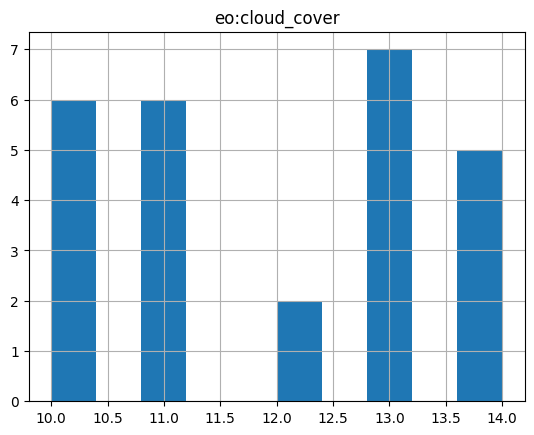

In [160]:
# Display cloud-cover values as histogram to show that range is taken into account
stac_json = results.item_collection_as_dict()
gdf = gpd.GeoDataFrame.from_features(stac_json)
try:
  _ = gdf[['title','eo:cloud_cover']].hist()
except:
  print("eo:cloud_cover information is not available.")

## Further Reading

| **ID**  | **Title** | 
| -------- | --------- | 
| `RD11` <a name="RD11"></a> | [STAC API - Item Search](https://github.com/radiantearth/stac-api-spec/tree/main/item-search) |
| `RD12` <a name="RD12"></a> | [STAC API - Filter Extension](https://github.com/stac-api-extensions/filter) |
| `RD13` <a name="RD13"></a> | [STAC Catalog Specification](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) | 
| `RD14` <a name="RD14"></a> | [STAC Collection Specification](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) | 
| `RD15` <a name="RD15"></a>| [STAC API Specification](https://github.com/radiantearth/stac-api-spec)  | 
| `RD16` <a name="RD16"></a> | [STAC Item Specification](https://github.com/radiantearth/stac-spec/tree/master/item-spec)   | 
| `RD17` <a name="RD17"></a> | [PySTAC Documentation](https://pystac.readthedocs.io/en/stable/) | 
| `RD18` <a name="RD18"></a> | [PySTAC Client Usage](https://pystac-client.readthedocs.io/en/stable/usage.html) | 
| `RD19` <a name="RD19"></a> | [ODC STAC - Plot STAC Items on a map ](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#Plot-STAC-Items-on-a-Map) | 
| `RD20` <a name="RD20"></a> | [OGC17-069r3, OGC API - Features - Part 1: Core](https://docs.opengeospatial.org/is/17-069r3/17-069r3.html) | 
| `RD21` <a name="RD21"></a> | [OGC19-079r2, OGC API - Features - Part 3: Filtering](https://docs.ogc.org/is/19-079r2/19-079r2.html)  | 
| `RD22` <a name="RD22"></a> | [OGC21-065r2, Common Query Language (CQL2)](https://docs.ogc.org/is/21-065r2/21-065r2.html)  | 
| `RD23` <a name="RD23"></a> | [RFC 7946 - The GeoJSON Format](https://datatracker.ietf.org/doc/html/rfc7946) | 
| `RD24` <a name="RD24"></a>| [JSON Schema: A Media Type for Describing JSON Documents, draft-handrews-json-schema-02](https://datatracker.ietf.org/doc/html/draft-handrews-json-schema-02) |
| `RD25` <a name="RD25"></a>| [STAC API - Collection Search](https://github.com/stac-api-extensions/collection-search) |






